# **Project : Prediction of music genre**
<hr>

<u>**Members**</u><br>
Tharnarch Thoranisttakul 63340500025<br>
Sorapas Weerakul 63340500064<br>
Athimet Aiewcharoen 63340500068
<hr>

In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.graph_objs import *
%matplotlib inline

import pandas_profiling as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Fetures selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2,VarianceThreshold
from sklearn.decomposition import PCA

# Models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, AffinityPropagation, Birch, MeanShift, OPTICS
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestCentroid , KNeighborsClassifier, NearestNeighbors, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

# Resampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import InstanceHardnessThreshold, RandomUnderSampler, NearMiss

# Classification metrics
from sklearn.metrics import classification_report, confusion_matrix , silhouette_score , rand_score , adjusted_mutual_info_score, mutual_info_score, auc

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# For Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Imputer 
from sklearn.impute import SimpleImputer, KNNImputer

# Make image directory (img)
import os
currDir = os.getcwd()
if not os.path.exists('img'):
    os.mkdir('img')

# Set global random seed
np.random.seed(1)

In [5]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap

cmap = ListedColormap([(0.235, 0.635, 0.827), (0.863, 0.863, 0.863)])
pieCmap = get_cmap('plasma')
snsPalette = [(0.235, 0.635, 0.827), (0.475, 0.027, 0.082)]
bgColor = (0.059, 0.067, 0.102)
axBGColor = (0.863, 0.863, 0.863)
barColor = (0.235, 0.635, 0.827)
axTextColor = (0.9, 0.9, 0.9)
textColor = (0, 0, 0)
titleColor = (0.9, 0.9, 0.9)
plt.rcParams['figure.facecolor'] = bgColor
plt.rcParams['axes.facecolor'] = axBGColor
plt.rcParams['axes.edgecolor'] = axTextColor
plt.rcParams['axes.labelcolor'] = axTextColor
plt.rcParams['xtick.color'] = axTextColor
plt.rcParams['ytick.color'] = axTextColor
plt.rcParams['text.color'] = textColor
plt.rcParams['axes.titlecolor'] = titleColor
plt.rcParams['legend.labelcolor'] = titleColor

plotlyGridcolor = 'rgba(0.9, 0.9, 0.9, 0.3)'

In [6]:
def modelTestProcess(df, getdummy = 0,verbose=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    df_model = df.copy()
    if getdummy == 1:
        df_model = pd.get_dummies(df_model, columns=['key','mode'],drop_first=True)
    X = df_model.drop(['music_genre'], axis=1)
    y = df_model['music_genre']
    # Scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # Splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    # Model
    LR_clf = LogisticRegression(n_jobs=-1, random_state=1,multi_class='multinomial')
    DT_clf = DecisionTreeClassifier(random_state=1)
    RF_clf = RandomForestClassifier(n_jobs=-1, random_state=1)
    KNN_clf = KNeighborsClassifier(n_jobs=-1)
    MLPC_clf = MLPClassifier(random_state=1)
    # SVC_clf = LinearSVC(random_state=1,multi_class='crammer_singer') # U take too much time
    modeldict = {'Logistic Regression Model':LR_clf, 'Decision Tree Model':DT_clf, 'Random Forest Model':RF_clf,
                'KNN Model':KNN_clf, 'MLPC Model':MLPC_clf}
    # Training
    for modelname, model in modeldict.items():
        model.fit(X_train, y_train)
        verboseprint(f'{modelname} trained.')
    # Testing
    resultdict = {}
    confusion_matrix_dict = {}
    f1scoredict = {}
    for modelname, model in modeldict.items():
        y_pred = model.predict(X_test)
        resultdict[modelname] = classification_report(y_test, y_pred)
        confusion_matrix_dict[modelname] = confusion_matrix(y_test, y_pred)
        f1scoredict[modelname] = f1_score(y_test, y_pred, average='weighted')
    for key, value in resultdict.items():
        verboseprint(f'Classification report of {key}',':\n',value)
        verboseprint(f'F1 score of {key} is {f1scoredict[key]}\n','-'*50)
    for key, value in f1scoredict.items():
        print(f'{key} (F1 score) : {value}')
    return modeldict,resultdict,confusion_matrix_dict,f1scoredict

### **Remove Outlier**

##### **Import Data**

In [7]:
df = pd.read_csv('Data/df_impute_knn.csv')
dfNum = df.select_dtypes(include=['float64'])  
dfCate = df.select_dtypes(include=['object'])
dfOutlier = df.copy()
df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,0.759,A#,Minor,Electronic
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,0.531,D,Minor,Electronic
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,0.333,G#,Major,Electronic
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,0.270,C#,Major,Electronic
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,0.323,F#,Major,Electronic


##### **Performance Benchmark**

In [8]:
modelBM, resultBM, confmatrixBM, f1BM = modelTestProcess(df, getdummy=1)

Logistic Regression Model (F1 score) : 0.524447965191827
Decision Tree Model (F1 score) : 0.44075530167155413
Random Forest Model (F1 score) : 0.5471645226550553
KNN Model (F1 score) : 0.47193630572630274
MLPC Model (F1 score) : 0.5821545904941349


We will be removing the outliers from the dataset using Anomaly Detection with Isolation Forest Algorithm, Local Outlier Factor Algorithm and KNN Algorithm.

#### **Isolation Forest**

In [9]:
dfOutlier_IF = dfOutlier.copy()
dfOutlier_IF

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,0.759,A#,Minor,Electronic
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,0.531,D,Minor,Electronic
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,0.333,G#,Major,Electronic
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,0.270,C#,Major,Electronic
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,0.323,F#,Major,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,0.330,C#,Major,Hip-Hop
49996,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,0.113,B,Major,Hip-Hop
49997,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,0.395,D,Major,Hip-Hop
49998,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,0.354,G,Minor,Hip-Hop


##### **Search for Hyperparameter**

In [10]:
def IFparamtuning(df,param,getdummy=0,verbose=0,n_estimators=[100],contamination=['auto'],max_features=[1.0]):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    df_model = df.copy()
    if getdummy == 1:
        df_model = pd.get_dummies(df_model, columns=['key','mode'],drop_first=True)
    X = df_model.drop(['music_genre'], axis=1)
    y = df_model['music_genre']
    # Scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    iteration = 1
    bestscore = 0
    bestmodel = None
    bestparam = None
    classreport = None
    print(f'All parameters are {param}') 
    for key, value in param.items():
        if key == 'n_estimators':
            n_estimators = value
        elif key == 'contamination':
            contamination = value
        elif key == 'max_features':
            max_features = value
    print(f'Number of Iteration: {len(n_estimators)*len(contamination)*len(max_features)}')
    print('-'*50)
    for i in n_estimators:
        for j in contamination:
            for k in max_features:
                verboseprint(f'Iteration number :{iteration}')
                verboseprint(f'n_estimators = {i}, contamination = {j}, max_features = {k}')
                IF_clf = IsolationForest(n_estimators=i, contamination=j, max_features=k, n_jobs=-1, random_state=1)
                IF_clf.fit(X)
                df_model['anomaly'] = IF_clf.predict(X)
                outliers = df_model[df_model['anomaly'] == -1]
                outlier_index = list(outliers.index)
                verboseprint(f'Number of outliers is {len(outlier_index)}')
                df_score = df_model[df_model['anomaly'] == 1].drop(['anomaly'], axis=1)
                df_model = df_model.drop('anomaly', axis=1)
                RF_clf = RandomForestClassifier(n_jobs=-1, random_state=1)
                X_score = df_score.drop(['music_genre'], axis=1)
                y_score = df_score['music_genre']
                # Scaling
                scalerScore = StandardScaler()
                X_score = scalerScore.fit_transform(X_score)
                # Splitting
                X_train, X_test, y_train, y_test = train_test_split(X_score, y_score, test_size=0.2, random_state=1)
                # Training
                RF_clf = RF_clf.fit(X_train, y_train)
                # Testing
                y_pred = RF_clf.predict(X_test)
                f1score = f1_score(y_test, y_pred, average='weighted')
                classreport = classification_report(y_test, y_pred)
                verboseprint(f'F1 score of Random Forest Model is {f1score}\n','-'*50)
                if f1score > bestscore:
                    bestscore = f1score
                    bestparam = {'n_estimators':i,'contamination':j,'max_features':k}
                    bestmodel = IF_clf
                iteration += 1
    print(f'Best score is {bestscore} with parameters {bestparam}')
    print(f'Best model is {bestmodel}')
    return bestparam,classreport,bestmodel

In [11]:
""""
'n_estimators':list(range(10,110,10))
'contamination':['auto',0.01, 0.02, 0.03]
Best score is 0.5538827260767094 with parameters {'n_estimators': 20, 'contamination': 0.01, 'max_features': 1.0}
Best model is IsolationForest(contamination=0.01, n_estimators=20, n_jobs=-1, random_state=1)

{'n_estimators':[20],
'contamination':[0.01],
'max_features':list(range(1,21,1))
Best score is 0.55187532899251 with parameters {'n_estimators': 20, 'contamination': 0.01, 'max_features': 2}
Best model is IsolationForest(contamination=0.01, max_features=2, n_estimators=20, n_jobs=-1,
                random_state=1)
"""
# list(range(10,110,10))
# parm,rep,mo = IFparamtuning(dfOutlier_IF,{'n_estimators':[10, 20, 30, 40, 50],
#                                         'contamination':['auto',0.01, 0.02, 0.03],
#                                         getdummy=1,
#                                         verbose=1)
pass

In [12]:
dfOutlier_IF_find = dfOutlier_IF.copy()
dfOutlier_IF_find = pd.get_dummies(dfOutlier_IF_find, columns=['key','mode'],drop_first=True)
X = dfOutlier_IF_find.drop(['music_genre'], axis=1)
y = dfOutlier_IF_find['music_genre']
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))

IF_clf = IsolationForest(n_jobs=-1, random_state=1)

minrange =10
maxrange = 110
step = 10
param_grid = {
              # 'n_estimators': list(range(minrange,maxrange,step)), 
              # 'max_samples': list(range(100, 500, 5)), 
              'contamination': [0.1, 0.2, 0.3, 0.4, 0.5], 
              # 'max_features': [15,20],
              }

scoring = {'f1score':make_scorer(f1_score,average='weighted')}
# scoring = {'Recall': make_scorer(recall_score, pos_label=-1, average='weighted')
#           ,'f1score': make_scorer(f1_score, pos_label=-1, average='weighted')}
# ,'AUC': make_scorer(roc_auc_score,
#                                 average='weighted',
#                                 multi_class='ovr',
#                                 labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}                                       

grid_dt_estimator = GridSearchCV(IF_clf, 
                                param_grid,
                                scoring=scoring, 
                                refit='f1score',
                                cv=4,
                                n_jobs=-1,
                                return_train_score=True
                                )

In [13]:
'''

Fitting 4 folds for each of 15 candidates, totalling 60 fits
tuned hpyerparameters :(best parameters)  {'max_features': 15, 'n_estimators': 140}
score : 0.05262386217850815

Fitting 4 folds for each of 18 candidates, totalling 72 fits
tuned hpyerparameters :(best parameters)  {'max_features': 15, 'n_estimators': 150}
score : 0.05270171149144254

Fitting 4 folds for each of 20 candidates, totalling 80 fits
tuned hpyerparameters :(best parameters)  {'max_features': 20, 'n_estimators': 100}
score : 0.05414193867457961

'''
# grid_dt_estimator.fit(X, y)
# print("tuned hpyerparameters :(best parameters) ",grid_dt_estimator.best_params_)
# print("score :",grid_dt_estimator.best_score_)
# results = grid_dt_estimator.cv_results_
pass

##### **Remove outlier**

In [14]:
X = dfOutlier_IF.copy()
y = X['music_genre']
X = pd.get_dummies(X, columns=['key','mode'], drop_first=True).drop(['music_genre'], axis=1)
scaler_IF = StandardScaler()
X = scaler_IF.fit_transform(X)

In [15]:
IF_clf = IsolationForest(n_estimators=20, contamination=0.01, n_jobs=-1, random_state=1)
IF_clf = IF_clf.fit(X,y)

In [16]:
dfOutlier_IF['anomalyscore'] = IF_clf.score_samples(X)
dfOutlier_IF['anomaly']= IF_clf.predict(X)
dfOutlier_IF

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre,anomalyscore,anomaly
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,0.759,A#,Minor,Electronic,-0.483615,1
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,0.531,D,Minor,Electronic,-0.517061,1
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,0.333,G#,Major,Electronic,-0.450166,1
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,0.270,C#,Major,Electronic,-0.378085,1
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,0.323,F#,Major,Electronic,-0.517650,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,0.330,C#,Major,Hip-Hop,-0.407122,1
49996,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,0.113,B,Major,Hip-Hop,-0.490252,1
49997,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,0.395,D,Major,Hip-Hop,-0.427725,1
49998,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,0.354,G,Minor,Hip-Hop,-0.419981,1


In [17]:
outliers=dfOutlier_IF.loc[dfOutlier_IF['anomaly']==-1]
outlier_index=list(outliers.index)
print(dfOutlier_IF['anomaly'].value_counts())
outliers

 1    49500
-1      500
Name: anomaly, dtype: int64


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre,anomalyscore,anomaly
288,34.0,0.01420,0.569,159880.0,0.988,0.920000,0.6320,-4.021,0.3760,126.150333,0.1420,F#,Minor,Electronic,-0.552367,-1
373,46.0,0.71600,0.589,366970.0,0.587,0.845000,0.1000,-14.527,0.3080,149.024000,0.5680,F#,Minor,Electronic,-0.580265,-1
614,37.0,0.00161,0.889,860761.0,0.480,0.835000,0.0514,-12.380,0.0747,100.002000,0.0751,A#,Minor,Electronic,-0.569811,-1
695,35.0,0.49400,0.247,207960.0,0.296,0.049100,0.0763,-13.472,0.0437,184.154000,0.1230,B,Minor,Electronic,-0.572137,-1
854,34.0,0.00519,0.621,274467.0,0.903,0.930000,0.1210,-9.548,0.1390,107.002000,0.5250,F#,Major,Electronic,-0.552307,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48252,64.0,0.81900,0.471,243724.0,0.784,0.000011,0.1070,-8.250,0.8830,160.833000,0.2580,B,Minor,Hip-Hop,-0.568867,-1
49083,60.0,0.71400,0.802,206811.0,0.616,0.000000,0.0929,-9.740,0.7120,91.894000,0.6060,D,Major,Hip-Hop,-0.553294,-1
49430,48.0,0.79300,0.589,52907.0,0.391,0.000000,0.9320,-15.681,0.9320,89.046000,0.7210,F#,Minor,Hip-Hop,-0.577240,-1
49650,53.0,0.47000,0.633,59118.0,0.506,0.000000,0.9590,-16.808,0.8630,112.074667,0.7840,C#,Major,Hip-Hop,-0.557180,-1


In [18]:
df_outliertest_IF = dfOutlier_IF[dfOutlier_IF['anomaly']==1].drop(['anomaly','anomalyscore'], axis=1)
df_outliertest_IF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49500 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        49500 non-null  float64
 1   acousticness      49500 non-null  float64
 2   danceability      49500 non-null  float64
 3   duration_ms       49500 non-null  float64
 4   energy            49500 non-null  float64
 5   instrumentalness  49500 non-null  float64
 6   liveness          49500 non-null  float64
 7   loudness          49500 non-null  float64
 8   speechiness       49500 non-null  float64
 9   tempo             49500 non-null  float64
 10  valence           49500 non-null  float64
 11  key               49500 non-null  object 
 12  mode              49500 non-null  object 
 13  music_genre       49500 non-null  object 
dtypes: float64(11), object(3)
memory usage: 5.7+ MB


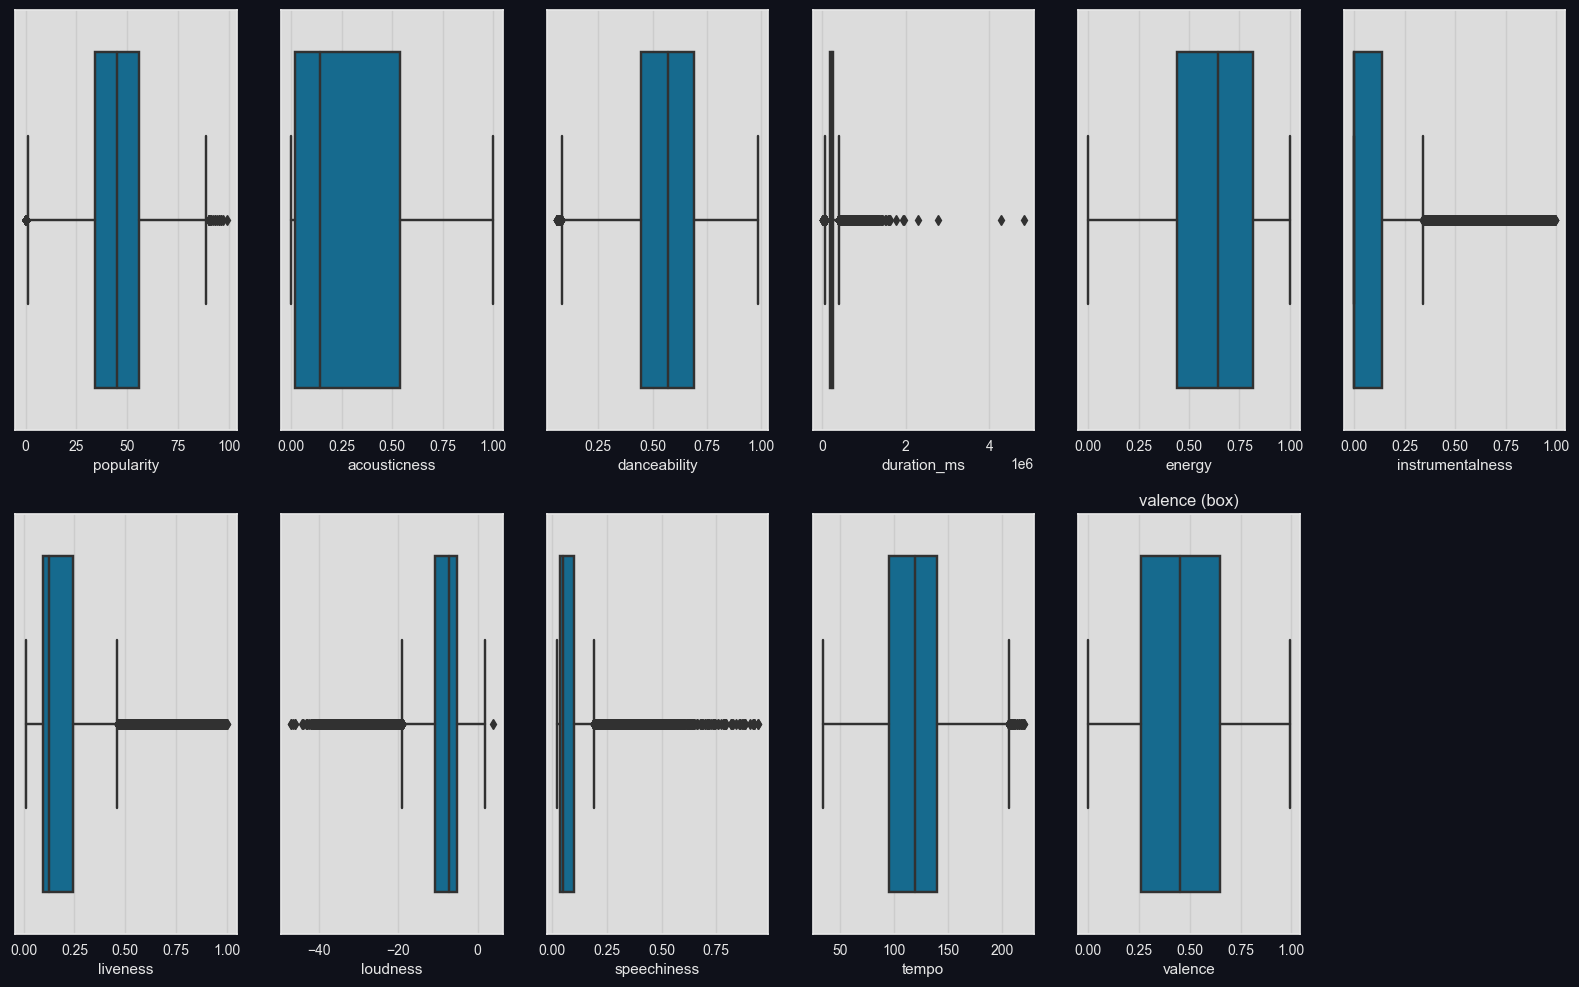

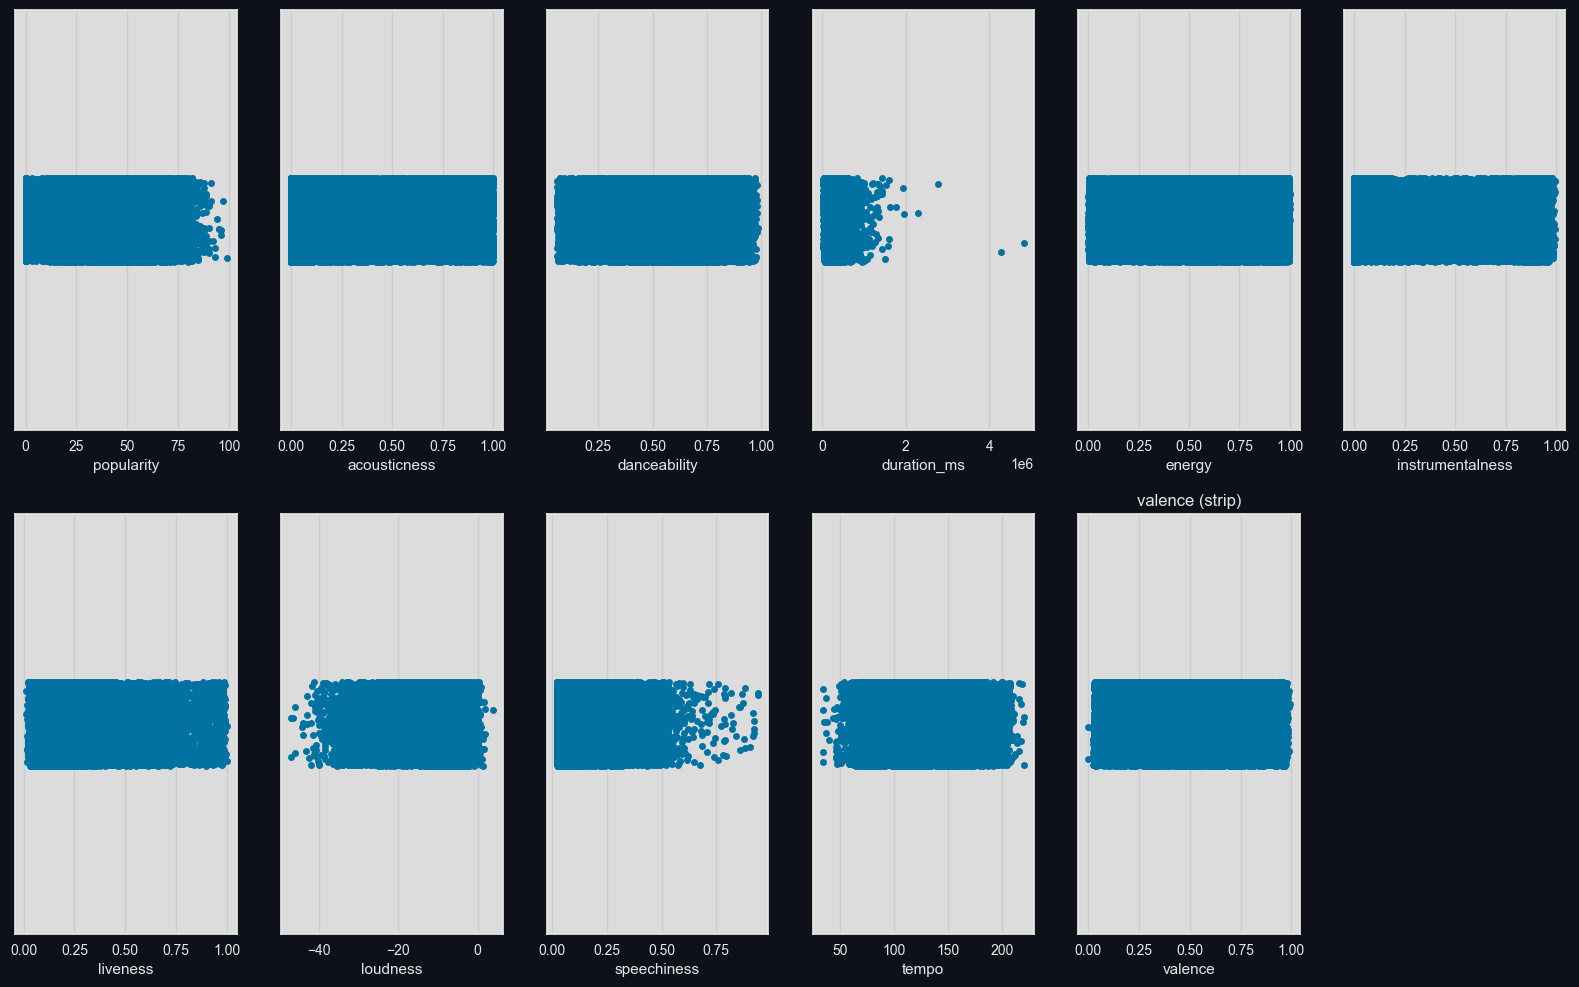

In [19]:
outlierplotboxALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotboxALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.boxplot(x=df_outliertest_IF[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (box)')
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=df_outliertest_IF[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

##### **Performance**

In [20]:
modelBM_IF, resultBM_IF, confmatrixBM_IF, f1BM_IF = modelTestProcess(df_outliertest_IF, getdummy=1)

Logistic Regression Model (F1 score) : 0.5289420692335385
Decision Tree Model (F1 score) : 0.44370417825324693
Random Forest Model (F1 score) : 0.5500204039684669
KNN Model (F1 score) : 0.46712937911671276
MLPC Model (F1 score) : 0.5714024337810822


#### **Local Outlier Factor**

In [21]:
from sklearn.neighbors import LocalOutlierFactor
dfOutlier_LOF = dfOutlier.copy()
dfOutlier_LOF = pd.get_dummies(dfOutlier_LOF, columns=['key','mode'], drop_first=True)
dfOutlier_LOF

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,...,0,0,0,0,0,0,0,0,0,1
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,...,0,0,1,0,0,0,0,0,0,1
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,...,0,0,0,0,0,0,0,0,1,0
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,...,0,1,0,0,0,0,0,0,0,0
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,...,0,1,0,0,0,0,0,0,0,0
49996,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,...,0,0,0,0,0,0,0,0,0,0
49997,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,...,0,0,1,0,0,0,0,0,0,0
49998,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,...,0,0,0,0,0,0,0,1,0,1


##### **Search for Hyperparameter**

In [22]:
# Impute missing values
dfOutlier_LOF_find = dfOutlier_LOF.copy()
X = dfOutlier_LOF_find.drop(['music_genre'], axis=1)
y = dfOutlier_LOF_find['music_genre']
colX = X.columns
toend = ['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop']
coltoend = [['music_genre']]
y = y.apply(lambda x: toend.index(x))
scalerLOF = StandardScaler()
X = scalerLOF.fit_transform(X)

KN_LOF_param = [{ 
              'n_neighbors' : range(10,60,10),
              # 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
              # 'leaf_size' : range(10,60,10),
              }]

KN_LOF_clf = KNeighborsClassifier(n_jobs=-1,algorithm='ball_tree')

f1sc = make_scorer(f1_score, average='weighted')

grid_KN_LOF_clf = GridSearchCV(KN_LOF_clf, 
                        KN_LOF_param,
                        scoring=f1sc, 
                        refit=True,
                        cv=4,
                        n_jobs=-1,
                        verbose=3,
                        return_train_score=True)

In [23]:
# grid_KN_LOF_clf.fit(X, y)
# print("tuned hpyerparameters :(best parameters) ",grid_KN_LOF_clf.best_params_)
# print("score :",grid_KN_LOF_clf.best_score_)

"""
Fitting 4 folds for each of 4 candidates, totalling 16 fits
tuned hpyerparameters :(best parameters)  {'algorithm': 'ball_tree'}
score : 0.4638039248476319

Fitting 4 folds for each of 5 candidates, totalling 20 fits
tuned hpyerparameters :(best parameters)  {'n_neighbors': 20}
score : 0.4852892750123391
"""
pass

##### **Remove outlier**

In [24]:
X = dfOutlier_LOF.drop(['music_genre'], axis=1)
y = dfOutlier_LOF['music_genre']
colX = X.columns
scalerLOF = StandardScaler()
X = scalerLOF.fit_transform(X)

clf_LOF = LocalOutlierFactor(n_neighbors=20, algorithm='ball_tree', n_jobs=-1)
clf_LOF.fit_predict(X)
lof_LOF  = clf_LOF.negative_outlier_factor_

In [25]:
thresh_LOF = np.quantile(lof_LOF, .03)
dfoutlier_LOF = dfOutlier_LOF[lof_LOF <= thresh_LOF]
dfNormal_LOF = dfOutlier_LOF[lof_LOF > thresh_LOF]
print(thresh_LOF)
dfNormal_LOF

-1.3476365914081732


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,...,0,0,0,0,0,0,0,0,0,1
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,...,0,0,1,0,0,0,0,0,0,1
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,...,0,0,0,0,0,0,0,0,1,0
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,...,0,1,0,0,0,0,0,0,0,0
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,...,0,1,0,0,0,0,0,0,0,0
49996,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,...,0,0,0,0,0,0,0,0,0,0
49997,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,...,0,0,1,0,0,0,0,0,0,0
49998,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,...,0,0,0,0,0,0,0,1,0,1


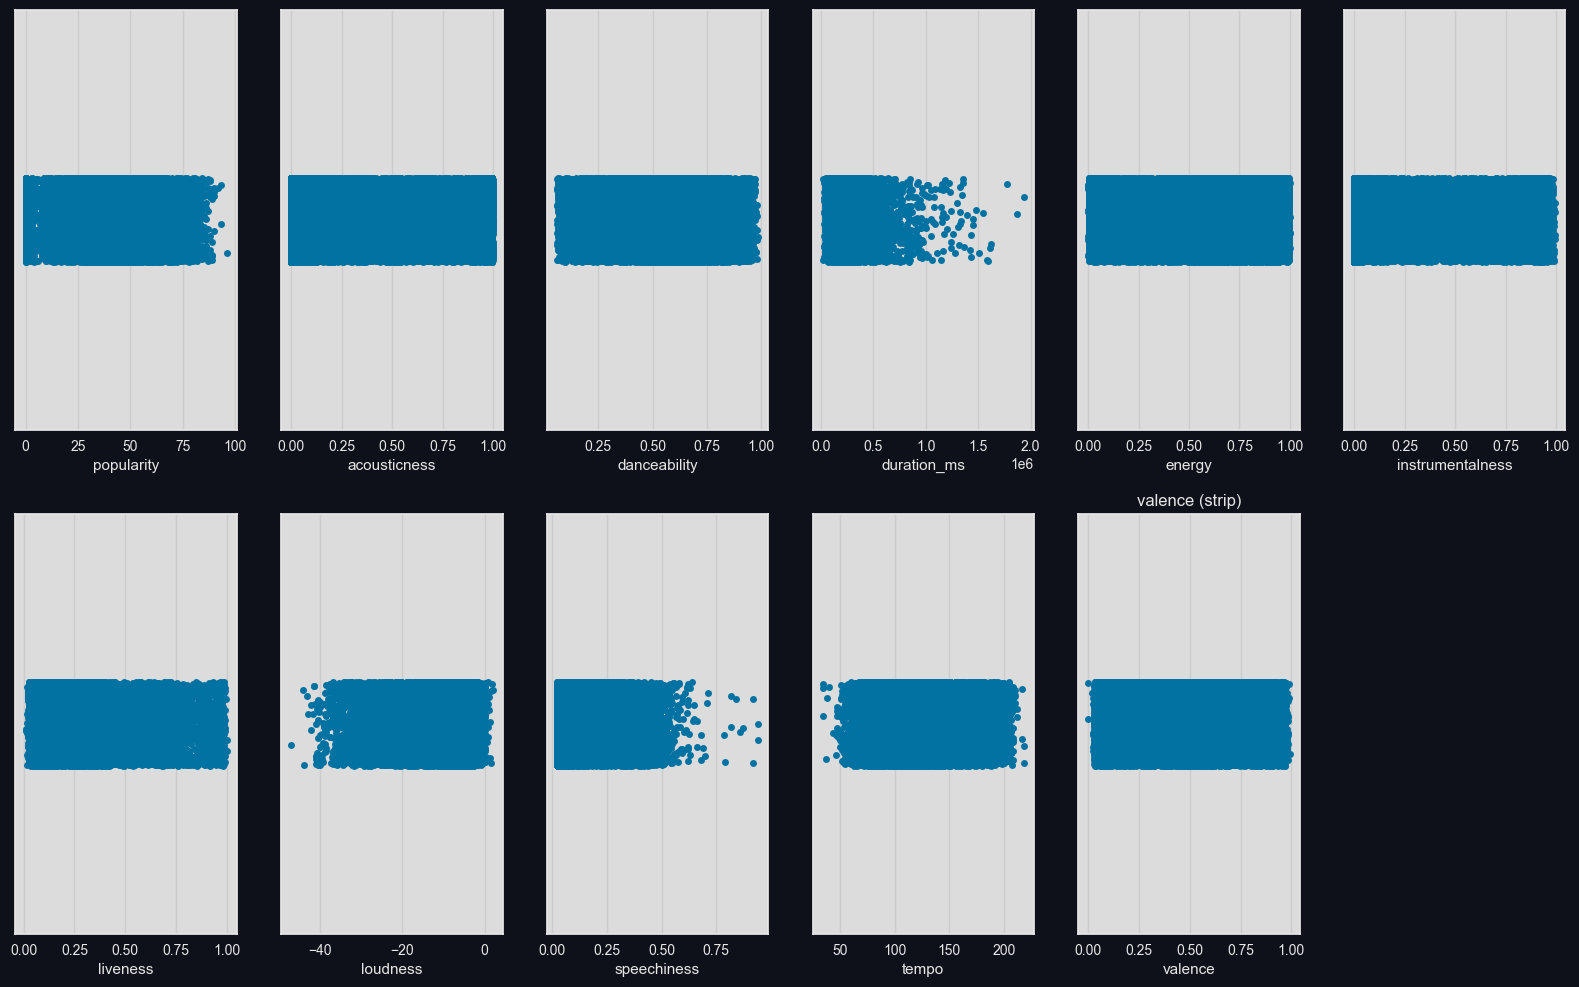

In [26]:
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=dfNormal_LOF[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

##### **Performance**

In [27]:
modelBM_LOF, resultBM_LOF, confmatrixBM_LOF, f1BM_LOF = modelTestProcess(dfNormal_LOF, getdummy=0)

Logistic Regression Model (F1 score) : 0.5357630309884516
Decision Tree Model (F1 score) : 0.4436429258486196
Random Forest Model (F1 score) : 0.5509402128633895
KNN Model (F1 score) : 0.4709673156959691
MLPC Model (F1 score) : 0.582190201113514


#### **Nearest Neighbors**

In [28]:
# create arrays
dfnbrs = dfOutlier.copy()
dfnbrsOrig = dfnbrs.copy()
# Unsupervised learning we consider all features even the target
X = pd.get_dummies(dfnbrs, columns=['key','mode','music_genre'], drop_first=True)
X

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,mode_Minor,music_genre_Anime,music_genre_Blues,music_genre_Classical,music_genre_Country,music_genre_Electronic,music_genre_Hip-Hop,music_genre_Jazz,music_genre_Rap,music_genre_Rock
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,...,1,0,0,0,0,1,0,0,0,0
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,...,1,0,0,0,0,1,0,0,0,0
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,...,0,0,0,0,0,1,0,0,0,0
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,...,0,0,0,0,0,1,0,0,0,0
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,...,0,0,0,0,0,0,1,0,0,0
49996,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,...,0,0,0,0,0,0,1,0,0,0
49997,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,...,0,0,0,0,0,0,1,0,0,0
49998,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,...,1,0,0,0,0,0,1,0,0,0


โดยจะใช้ HYPERPARAMETER ที่ได้จาก Section ที่แล้ว คือ n_neighbors = 20, algorithm = 'ball_tree'

##### **Remove outlier**

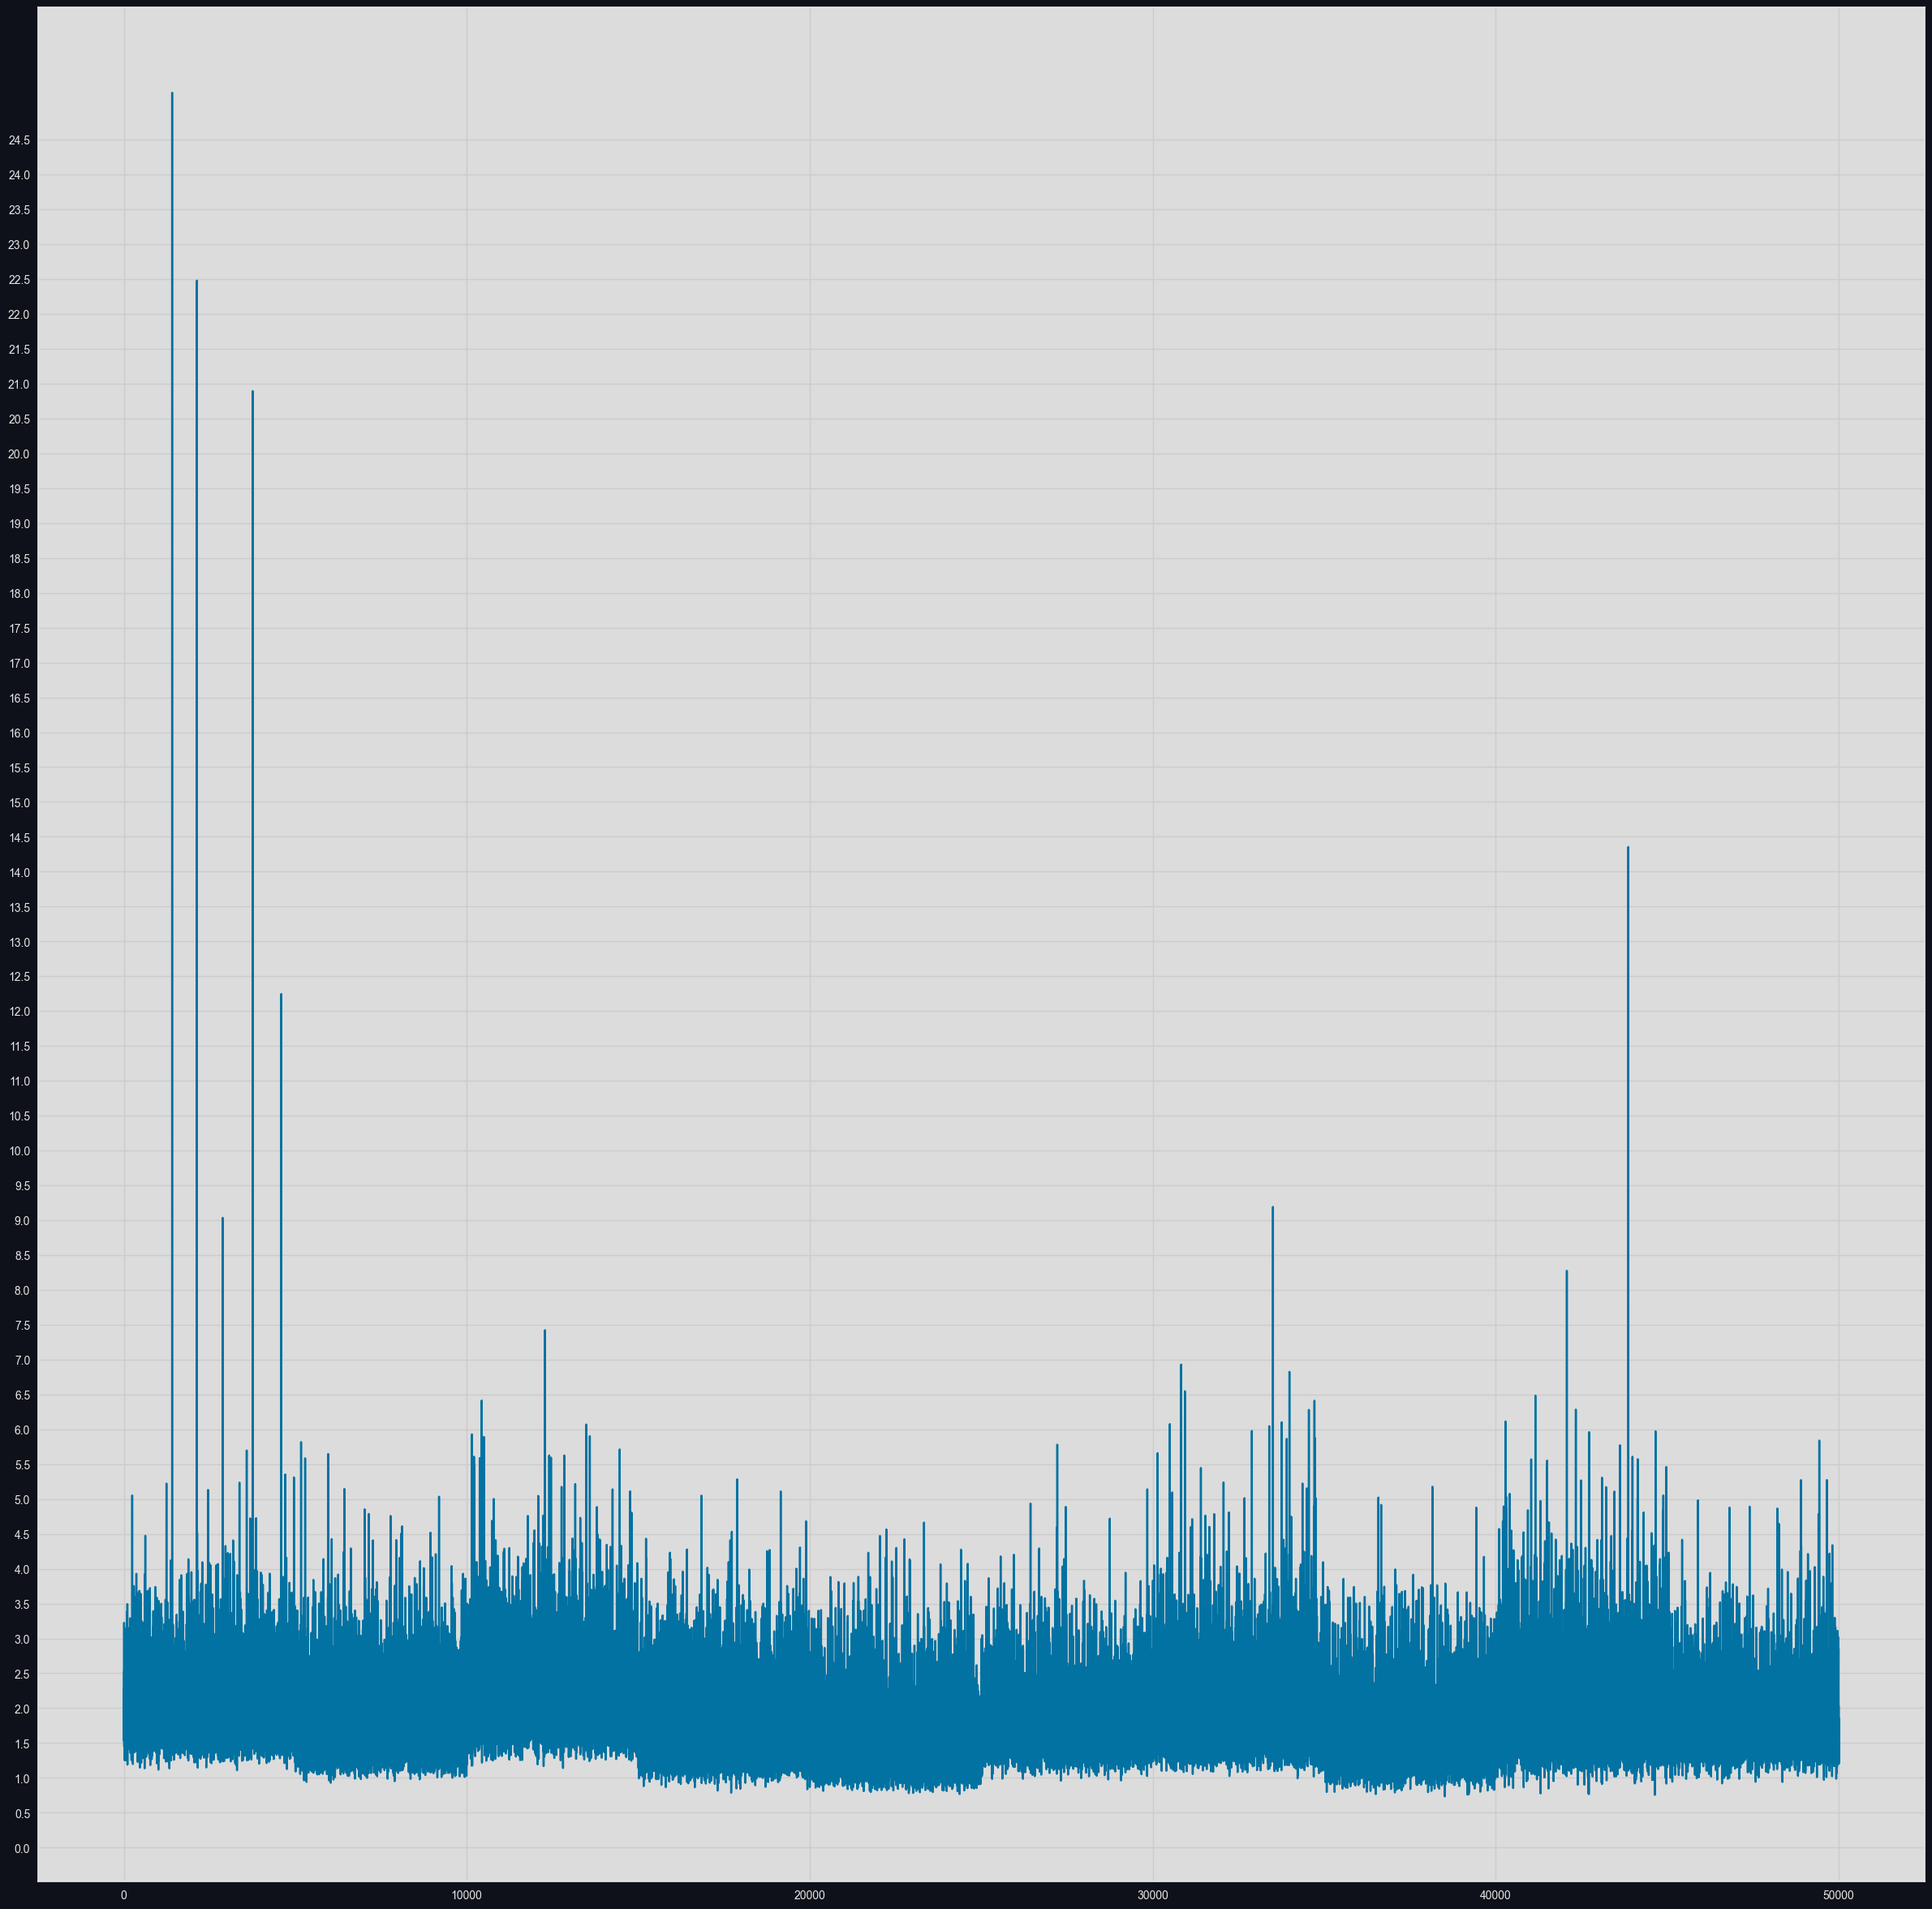

In [29]:
# instantiate model
scaler = StandardScaler()
X = scaler.fit_transform(X)
nbrs = NearestNeighbors(n_jobs=-1,n_neighbors=20,algorithm='ball_tree').fit(X)
# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(X)
# plot mean of k-distances of each observation
anomalyPlot, ax = plt.subplots(1, 1, figsize=(30, 30))
ax.set_yticks(np.arange(0, 25, 0.5))
ax.plot(distances.mean(axis =1))

In [30]:
# visually determine cutoff values > 2.8
outlier_index = np.where(distances.mean(axis = 1) > 2.8)
# filter outlier values
outlier_values = dfnbrsOrig.iloc[outlier_index]
outlier_values

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre
10,30.0,0.85500,0.607,170463.000000,0.158,0.000000,0.106,-13.787,0.0345,57.528000,0.307,F#,Minor,Electronic
16,59.0,0.13600,0.336,216077.666667,0.746,0.000000,0.737,-4.315,0.0685,151.756000,0.210,C#,Minor,Electronic
20,44.0,0.00804,0.516,241877.000000,0.920,0.614000,0.801,-4.370,0.0942,145.027000,0.332,A,Minor,Electronic
43,43.0,0.16900,0.685,219436.333333,0.909,0.000663,0.942,-7.627,0.0430,119.978000,0.962,C,Major,Electronic
60,27.0,0.21600,0.626,337091.000000,0.362,0.867000,0.681,-14.892,0.0479,109.948000,0.107,C,Major,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49880,49.0,0.01100,0.431,528880.000000,0.898,0.001150,0.523,-4.233,0.1660,96.701000,0.192,C#,Minor,Hip-Hop
49900,54.0,0.04200,0.688,185747.000000,0.723,0.874000,0.196,-5.259,0.0463,171.774000,0.959,A,Minor,Hip-Hop
49959,59.0,0.08470,0.929,215200.000000,0.737,0.000000,0.861,-6.424,0.1020,126.653667,0.886,G#,Major,Hip-Hop
49977,58.0,0.72300,0.541,197721.000000,0.399,0.000060,0.111,-10.414,0.1310,203.893000,0.392,B,Major,Hip-Hop


In [31]:
dropOutliers = outlier_index[0].tolist()
dfnbrsOrig.drop(dropOutliers, axis=0, inplace=True)
dfnbrsOrig.reset_index(drop=True, inplace=True)
dfnbrsOrig

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,0.759,A#,Minor,Electronic
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,0.531,D,Minor,Electronic
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,0.333,G#,Major,Electronic
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,0.270,C#,Major,Electronic
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,0.323,F#,Major,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46472,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,0.330,C#,Major,Hip-Hop
46473,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,0.113,B,Major,Hip-Hop
46474,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,0.395,D,Major,Hip-Hop
46475,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,0.354,G,Minor,Hip-Hop


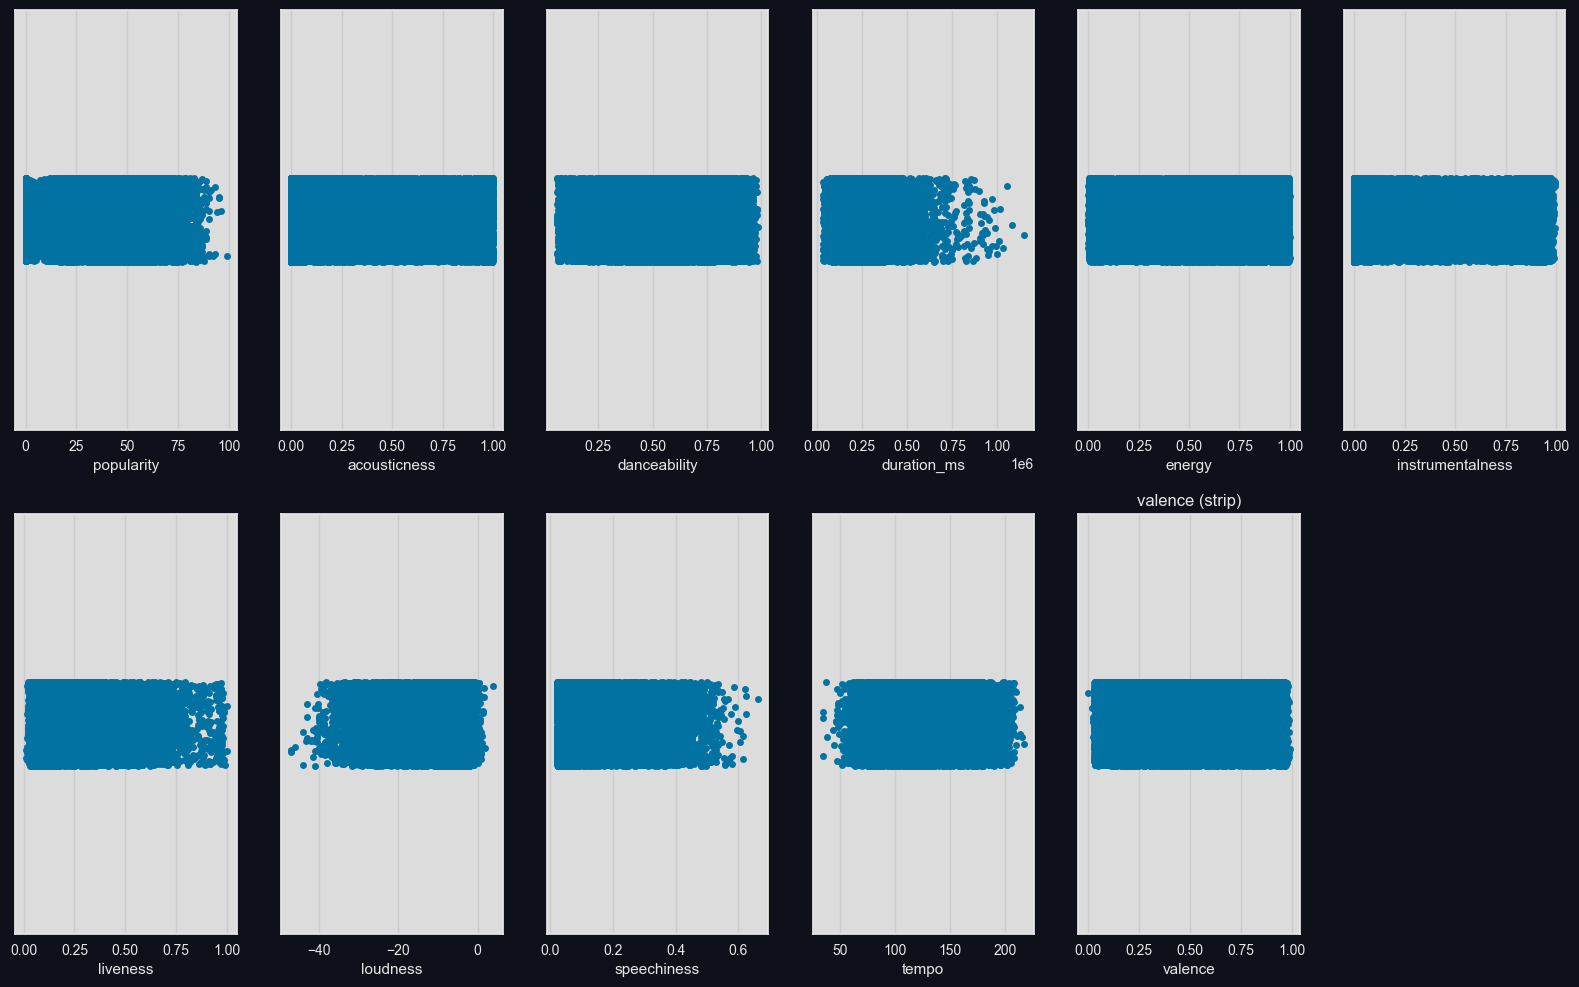

In [32]:
outlierplotstripALL, axes = plt.subplots(2, 6, figsize=(20, 12))
outlierplotstripALL.delaxes(axes[1,5])
for idx, col in enumerate(dfNum.columns):
    sns.stripplot(x=dfnbrsOrig[col],ax=axes[idx//6, idx%6])
    plt.title(col + ' (strip)')

##### **Performance**

In [33]:
modelBM_KN, resultBM_KN, confmatrixBM_KN, f1BM_KN = modelTestProcess(dfnbrsOrig, getdummy=1)

Logistic Regression Model (F1 score) : 0.5391570061625844
Decision Tree Model (F1 score) : 0.44469774223072245
Random Forest Model (F1 score) : 0.5567616271692278
KNN Model (F1 score) : 0.4779681649136388
MLPC Model (F1 score) : 0.5867948169999857


In [34]:
"""
BM
{'Logistic Regression Model': 0.524447965191827,
 'Decision Tree Model': 0.43945745895900645,
 'Random Forest Model': 0.5495947325317898,
 'KNN Model': 0.47201620184508275,
 'MLPC Model': 0.5820716052140181}

 K=5 th=3.5
 {'Logistic Regression Model': 0.5267810382941709,
 'Decision Tree Model': 0.44051382014335133,
 'Random Forest Model': 0.553135221178713,
 'KNN Model': 0.47181105767624826,
 'MLPC Model': 0.5644229849392003}

 K=20 th=2.5
 {'Logistic Regression Model': 0.5534657308220577,
 'Decision Tree Model': 0.45364463234145963,
 'Random Forest Model': 0.5591870916498062,
 'KNN Model': 0.4828599318951609,
 'MLPC Model': 0.5966668901650811}

  K=20 th=2.8
 {'Logistic Regression Model': 0.5391570061625844,
 'Decision Tree Model': 0.4440435845051865,
 'Random Forest Model': 0.5567451105220543,
 'KNN Model': 0.4779681649136388,
 'MLPC Model': 0.5853447432208643}

 K=20 th=3.0
{'Logistic Regression Model': 0.5416241410065534,
 'Decision Tree Model': 0.4450136318014417,
 'Random Forest Model': 0.5503797141498078,
 'KNN Model': 0.47676748749978265,
 'MLPC Model': 0.5778236970506728}

"""
pass

#### **Conclusion**

<table>
 <tr>
  <td rowspan="2" style="text-align:center">Model</td>
  <td colspan="4" style="text-align:center">f1-Score</td>
 </tr>
 <tr>
  <td style="text-align:center">Benchmark</td>
  <td style="text-align:center">Isolation Forest</td>
  <td style="text-align:center">Local Outlier Factor</td>
  <td style="text-align:center">Nearest Neighbors</td>
 </tr>
 <tr>
  <td style="text-align:center">Logistic Regression</td>
  <td style="text-align:center">0.524447965191827</td>
  <td style="text-align:center">0.5289420692335385</td>
  <td style="text-align:center">0.5357630309884516</td>
  <td style="text-align:center">0.5391570061625844</td>
 </tr>
<tr>
  <td style="text-align:center">Decision Tree</td>
  <td style="text-align:center">0.44075530167155413</td>
  <td style="text-align:center">0.44370417825324693</td>
  <td style="text-align:center">0.4436429258486196</td>
  <td style="text-align:center">0.44469774223072245</td>
 </tr>
<tr>
  <td style="text-align:center">Random Forest</td>
  <td style="text-align:center">0.5471645226550553</td>
  <td style="text-align:center">0.5500204039684669</td>
  <td style="text-align:center">0.5509402128633895</td>
  <td style="text-align:center">0.5567616271692278</td>
 </tr>
<tr>
  <td style="text-align:center">K-Nearest Neighbors</td>
  <td style="text-align:center">0.47193630572630274</td>
  <td style="text-align:center">0.46712937911671276</td>
  <td style="text-align:center">0.4709673156959691</td>
  <td style="text-align:center">0.4779681649136388</td>
 </tr>
<tr>
  <td style="text-align:center">Multi-layer Perceptron</td>
  <td style="text-align:center">0.5821545904941349</td>
  <td style="text-align:center">0.5714024337810822</td>
  <td style="text-align:center">0.582190201113514</td>
  <td style="text-align:center">0.5867948169999857</td>
 </tr>
</table>

In [35]:
dfOutlier_res = dfOutlier.copy()
dfOutlier_res = dfOutlier_res[lof_LOF > thresh_LOF]
dfOutlier_res.reset_index(drop=True, inplace=True)
dfOutlier_res

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,music_genre
0,27.0,0.00468,0.652,265662.333333,0.941,0.79200,0.115,-5.201,0.0748,100.889,0.759,A#,Minor,Electronic
1,31.0,0.01270,0.622,218293.000000,0.890,0.95000,0.124,-7.043,0.0300,115.002,0.531,D,Minor,Electronic
2,28.0,0.00306,0.620,215613.000000,0.755,0.01180,0.534,-4.617,0.0345,127.994,0.333,G#,Major,Electronic
3,34.0,0.02540,0.774,166875.000000,0.700,0.00253,0.157,-4.498,0.2390,128.014,0.270,C#,Major,Electronic
4,32.0,0.00465,0.638,222369.000000,0.587,0.90900,0.157,-6.266,0.0413,145.036,0.323,F#,Major,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48495,59.0,0.03340,0.913,210142.333333,0.574,0.00000,0.119,-7.022,0.2980,98.028,0.330,C#,Major,Hip-Hop
48496,72.0,0.15700,0.709,251860.000000,0.362,0.00000,0.109,-9.814,0.0550,122.043,0.113,B,Major,Hip-Hop
48497,51.0,0.00597,0.693,189483.000000,0.763,0.00000,0.143,-5.443,0.1460,131.079,0.395,D,Major,Hip-Hop
48498,65.0,0.08310,0.782,262773.000000,0.472,0.00000,0.106,-5.016,0.0441,75.886,0.354,G,Minor,Hip-Hop


In [36]:
dfOutlier_res.to_csv('Data/dfOutlier_res.csv', index=False)

### **Data Transformation**

#### **Import Data**

In [37]:
df = pd.read_csv('Data/dfOutlier_res.csv')
dfNum = df.select_dtypes(include=['float64'])
dfCate = df.select_dtypes(include=['object'])

#### **Performance Benchmark**

In [38]:
modelBM, resultBM, confmatrixBM, f1BM = modelTestProcess(df, getdummy=1)

Logistic Regression Model (F1 score) : 0.5357630309884516
Decision Tree Model (F1 score) : 0.4436429258486196
Random Forest Model (F1 score) : 0.5509402128633895
KNN Model (F1 score) : 0.4709673156959691
MLPC Model (F1 score) : 0.582190201113514


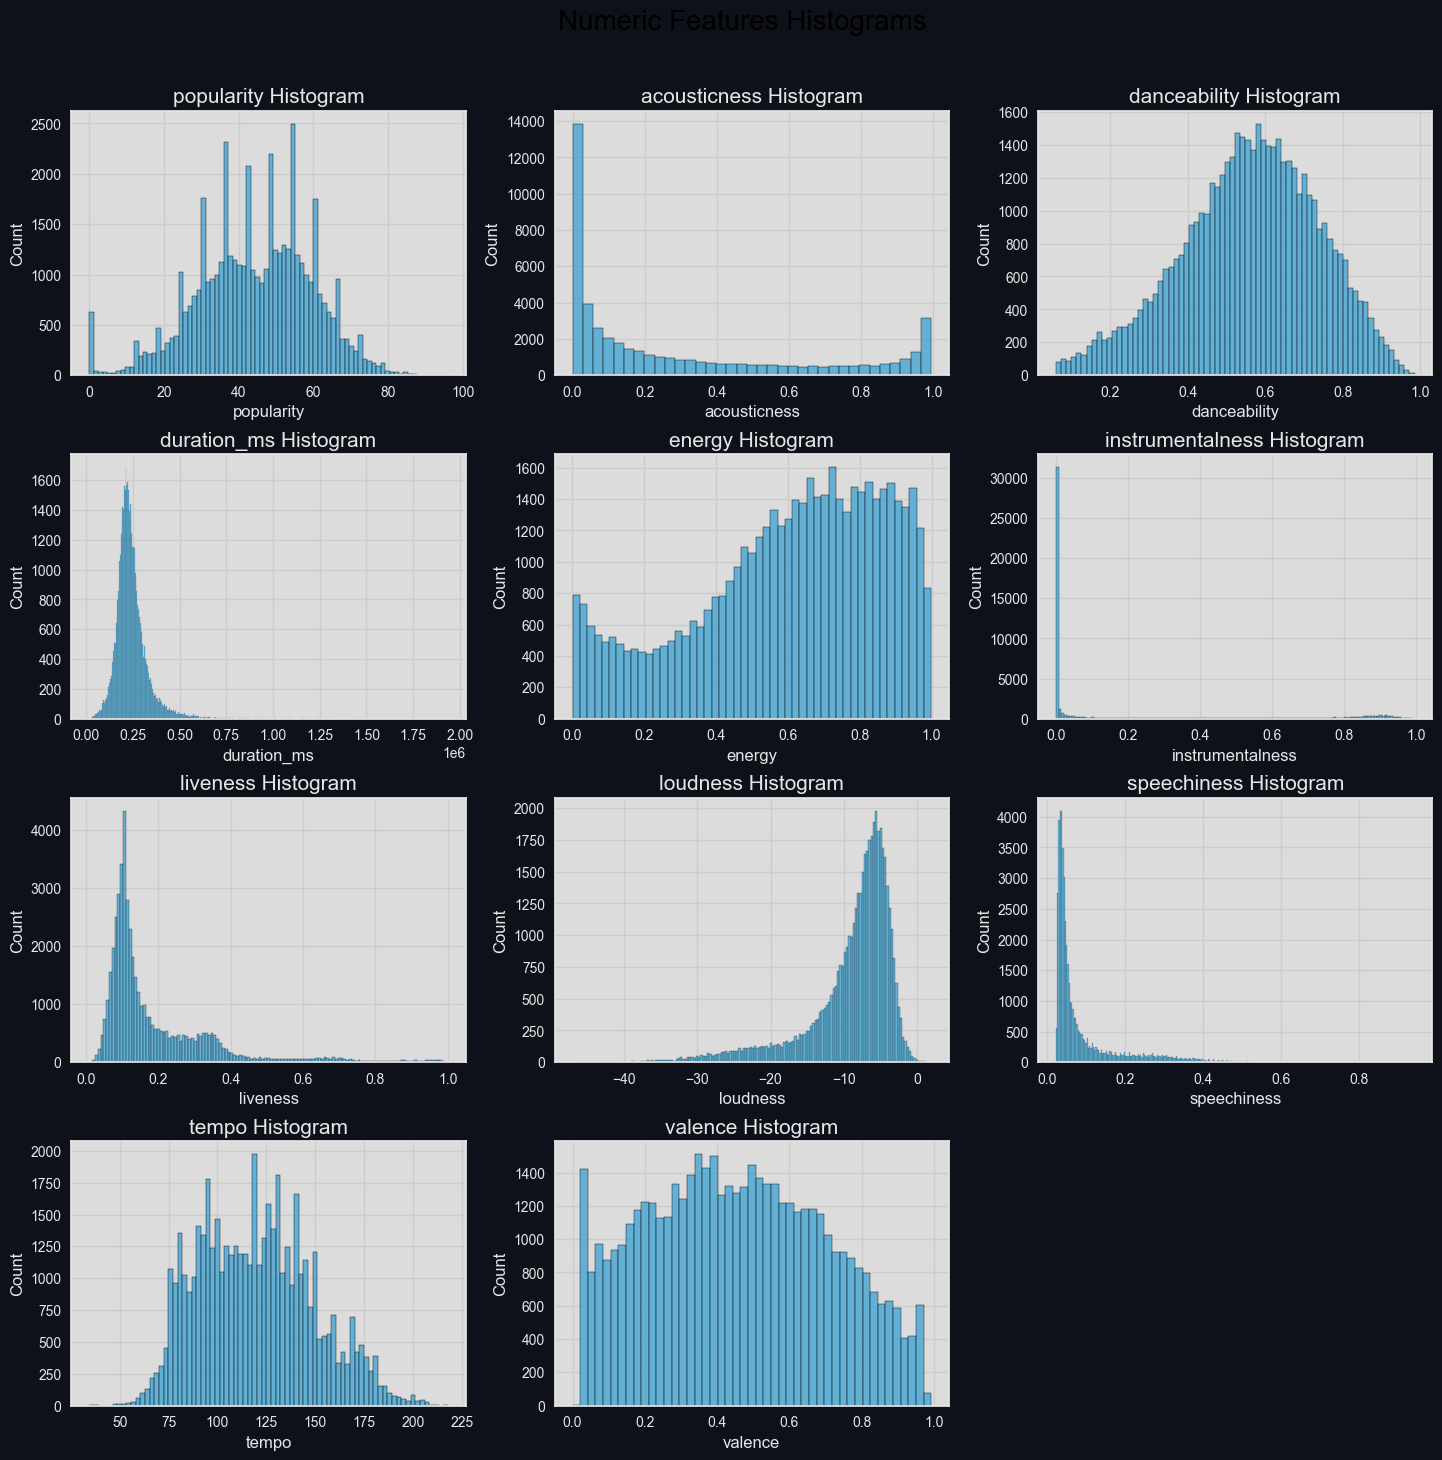

In [39]:
NumHists, axes = plt.subplots(4, 3, figsize=(15, 15))
NumHists.suptitle('Numeric Features Histograms', fontsize=20)
NumHists.tight_layout(pad=3.0)
for i, feature in enumerate(dfNum.columns):
    ax = axes[i//3, i%3]
    sns.histplot(dfNum[feature], ax=ax, color=snsPalette[0])
    ax.set_title(f'{feature} Histogram', fontsize=15)
    ax.set_xlabel(f'{feature}', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_facecolor(axBGColor)
NumHists.delaxes(axes[3,2])

#### **acousticness Feature**

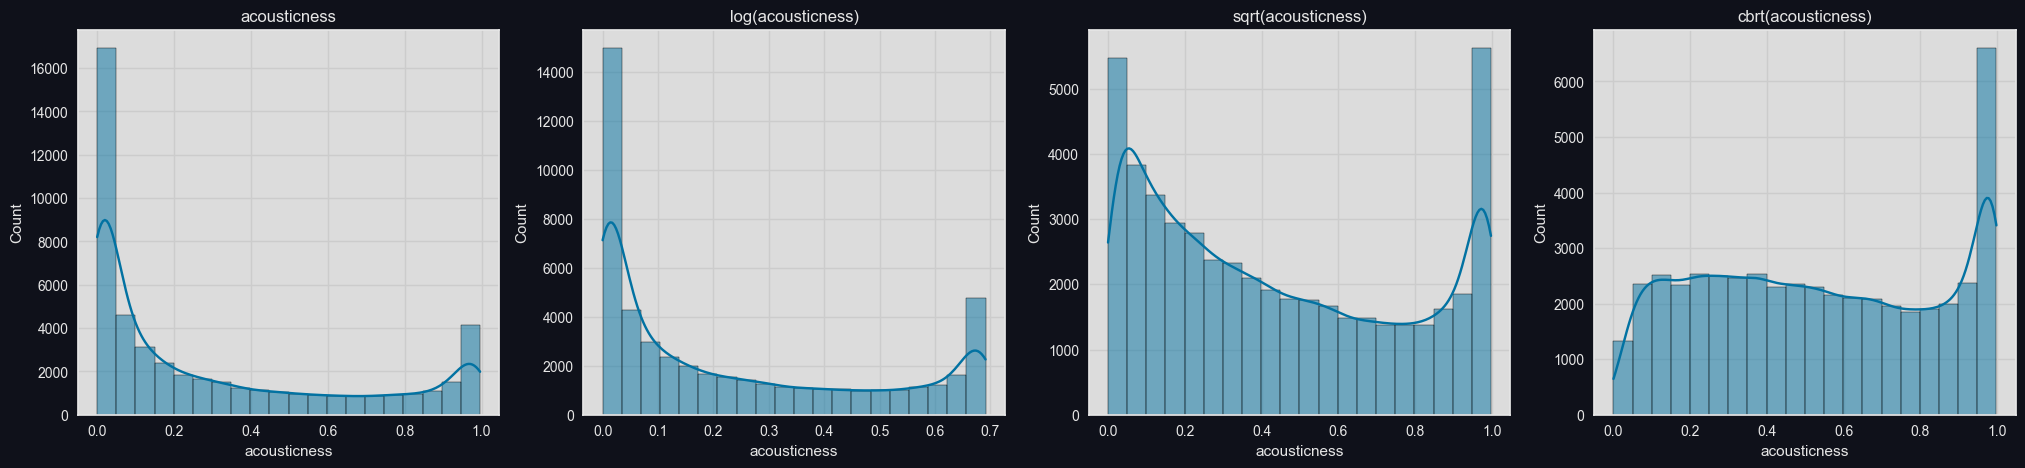

In [40]:
acousticness_base = df['acousticness']
acousticness_log = np.log(df["acousticness"]+1)
acousticness_sqrt = np.sqrt(df["acousticness"])
acousticness_cbrt = np.cbrt(df["acousticness"])
title = ['acousticness', 'log(acousticness)', 'sqrt(acousticness)', 'cbrt(acousticness)']
acousticnesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([acousticness_base, acousticness_log, acousticness_sqrt, acousticness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

#### **duration_ms Feature**

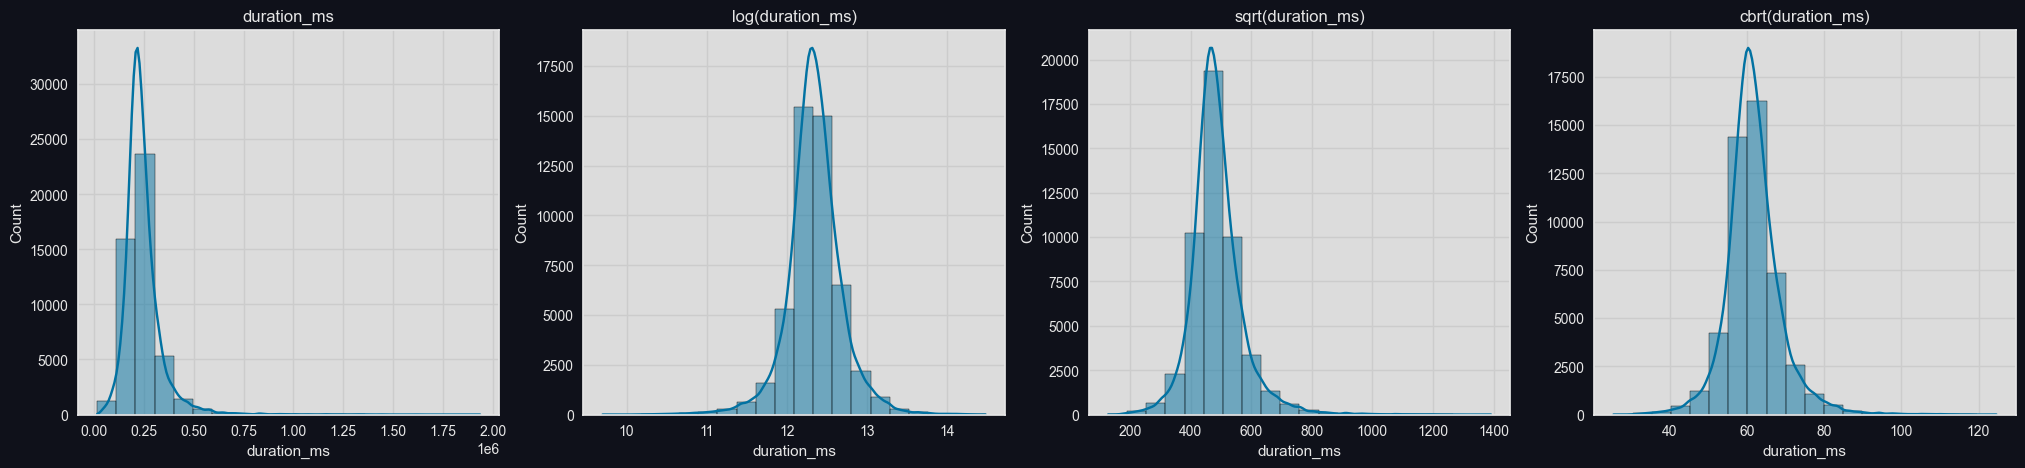

In [41]:
duration_ms_base = df['duration_ms']
duration_ms_log = np.log(df["duration_ms"])
duration_ms_sqrt = np.sqrt(df["duration_ms"])
duration_ms_cbrt = np.cbrt(df["duration_ms"])
title = ['duration_ms', 'log(duration_ms)', 'sqrt(duration_ms)', 'cbrt(duration_ms)']
duration_mstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([duration_ms_base, duration_ms_log, duration_ms_sqrt, duration_ms_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

In [42]:
dfDuration = df.copy()
dfDuration['duration_ms'] = duration_ms_log

modelBM_Duration_log, resultBM_Duration_log, confmatrixBM_Duration_log, f1BM_Duration_log = modelTestProcess(dfDuration, getdummy=1)

Logistic Regression Model (F1 score) : 0.533729915477468
Decision Tree Model (F1 score) : 0.4436566732328976
Random Forest Model (F1 score) : 0.5512512049916017
KNN Model (F1 score) : 0.4737041015601774
MLPC Model (F1 score) : 0.5827114233497143


In [43]:
dfDuration = df.copy()
dfDuration['duration_ms'] = duration_ms_cbrt

modelBM_Duration_cbrt, resultBM_Duration_cbrt, confmatrixBM_Duration_cbrt, f1BM_Duration_cbrt = modelTestProcess(dfDuration, getdummy=1)

Logistic Regression Model (F1 score) : 0.5340660741918921
Decision Tree Model (F1 score) : 0.4435410451989476
Random Forest Model (F1 score) : 0.5511484530893378
KNN Model (F1 score) : 0.47334517401172793
MLPC Model (F1 score) : 0.5816618263303287


#### **instrumentalness Feature**

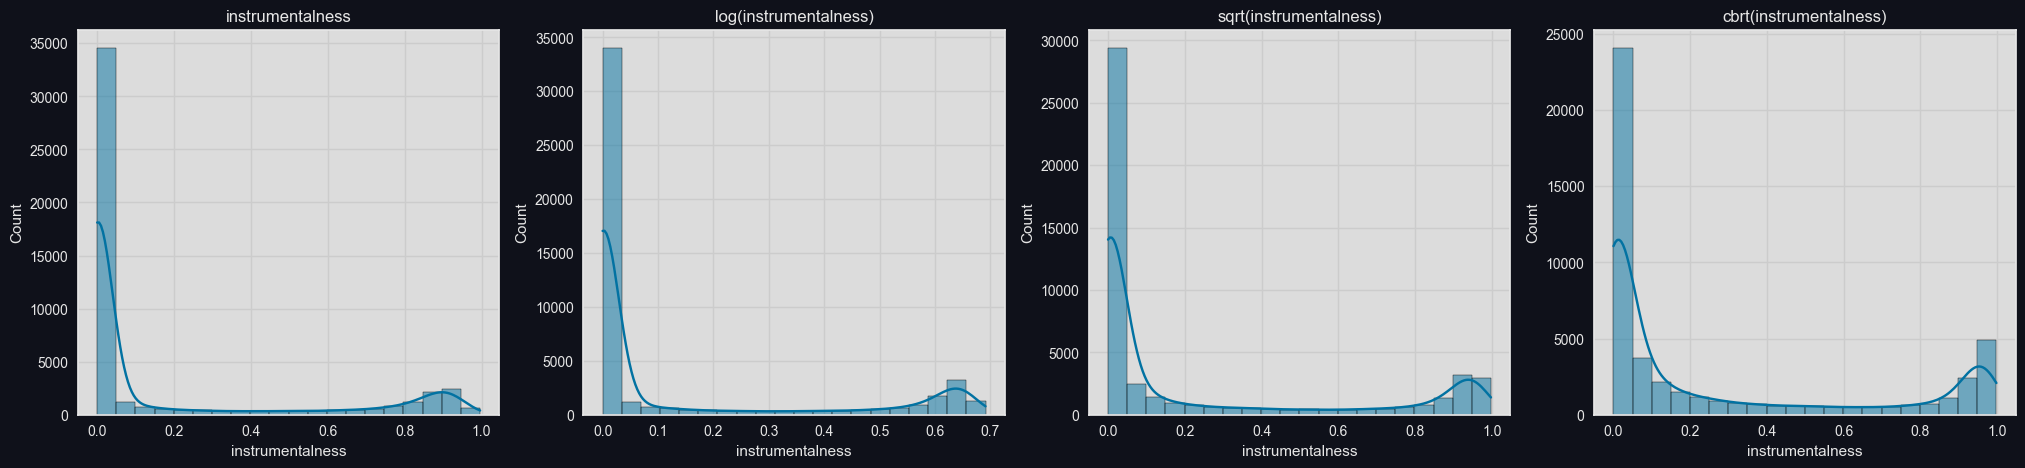

In [44]:
instrumentalness_base = df['instrumentalness']
instrumentalness_log = np.log(df["instrumentalness"]+1)
instrumentalness_sqrt = np.sqrt(df["instrumentalness"])
instrumentalness_cbrt = np.cbrt(df["instrumentalness"])
title = ['instrumentalness', 'log(instrumentalness)', 'sqrt(instrumentalness)', 'cbrt(instrumentalness)']
instrumentalnesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([instrumentalness_base, instrumentalness_log, instrumentalness_sqrt, instrumentalness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

#### **liveness Feature**

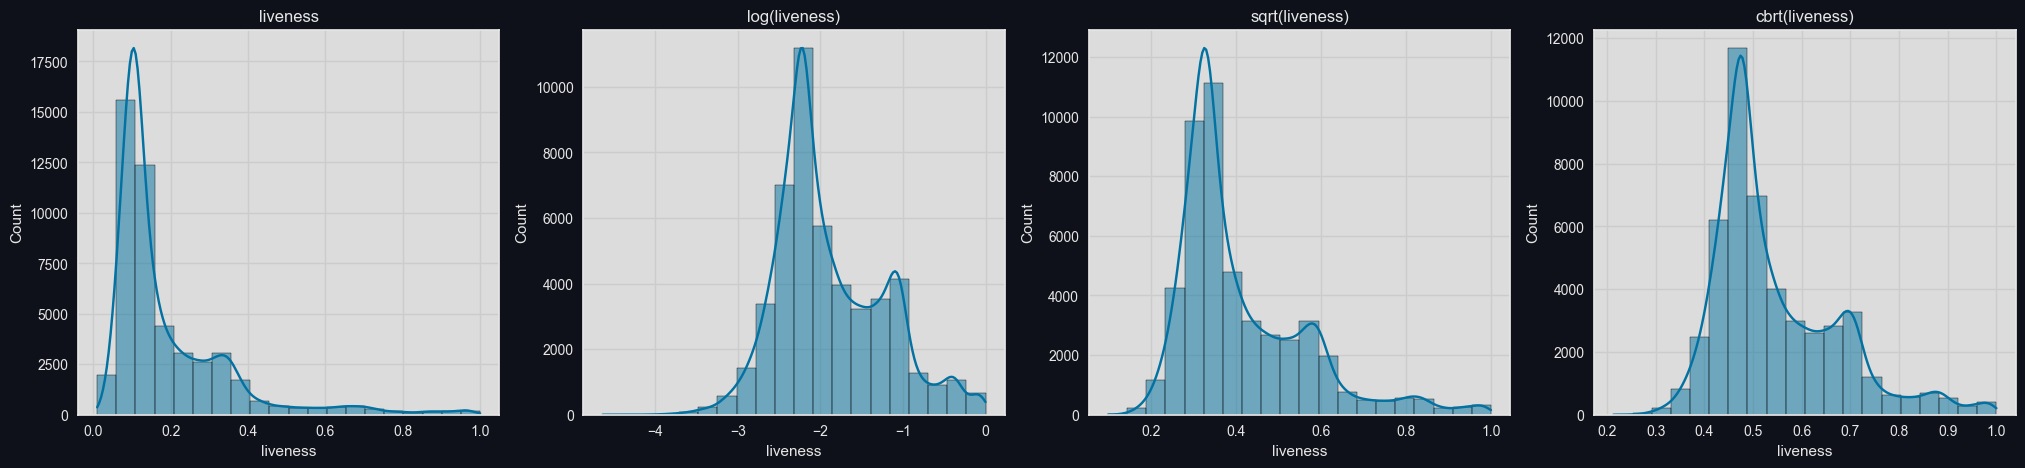

In [45]:
liveness_base = df['liveness']
liveness_log = np.log(df["liveness"])
liveness_sqrt = np.sqrt(df["liveness"])
liveness_cbrt = np.cbrt(df["liveness"])
title = ['liveness', 'log(liveness)', 'sqrt(liveness)', 'cbrt(liveness)']
livenesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([liveness_base, liveness_log, liveness_sqrt, liveness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

In [46]:
dfLiveness = df.copy()
dfLiveness['liveness'] = liveness_log

modelBM_Liveness_log, resultBM_Liveness_log, confmatrixBM_Liveness_log, f1BM_Liveness_log = modelTestProcess(dfLiveness, getdummy=1)

Logistic Regression Model (F1 score) : 0.5352213530678591
Decision Tree Model (F1 score) : 0.44385863942657255
Random Forest Model (F1 score) : 0.5512122179361562
KNN Model (F1 score) : 0.4680461766899694
MLPC Model (F1 score) : 0.5798518690845943


In [47]:
dfLiveness = df.copy()
dfLiveness['liveness'] = liveness_cbrt

modelBM_Liveness_cbrt, resultBM_Liveness_cbrt, confmatrixBM_Liveness_cbrt, f1BM_Liveness_cbrt = modelTestProcess(dfLiveness, getdummy=1)

Logistic Regression Model (F1 score) : 0.5360678083215004
Decision Tree Model (F1 score) : 0.44367396452787294
Random Forest Model (F1 score) : 0.551245198716268
KNN Model (F1 score) : 0.4699381115358704
MLPC Model (F1 score) : 0.5842755856272527


#### **loudness Feature**

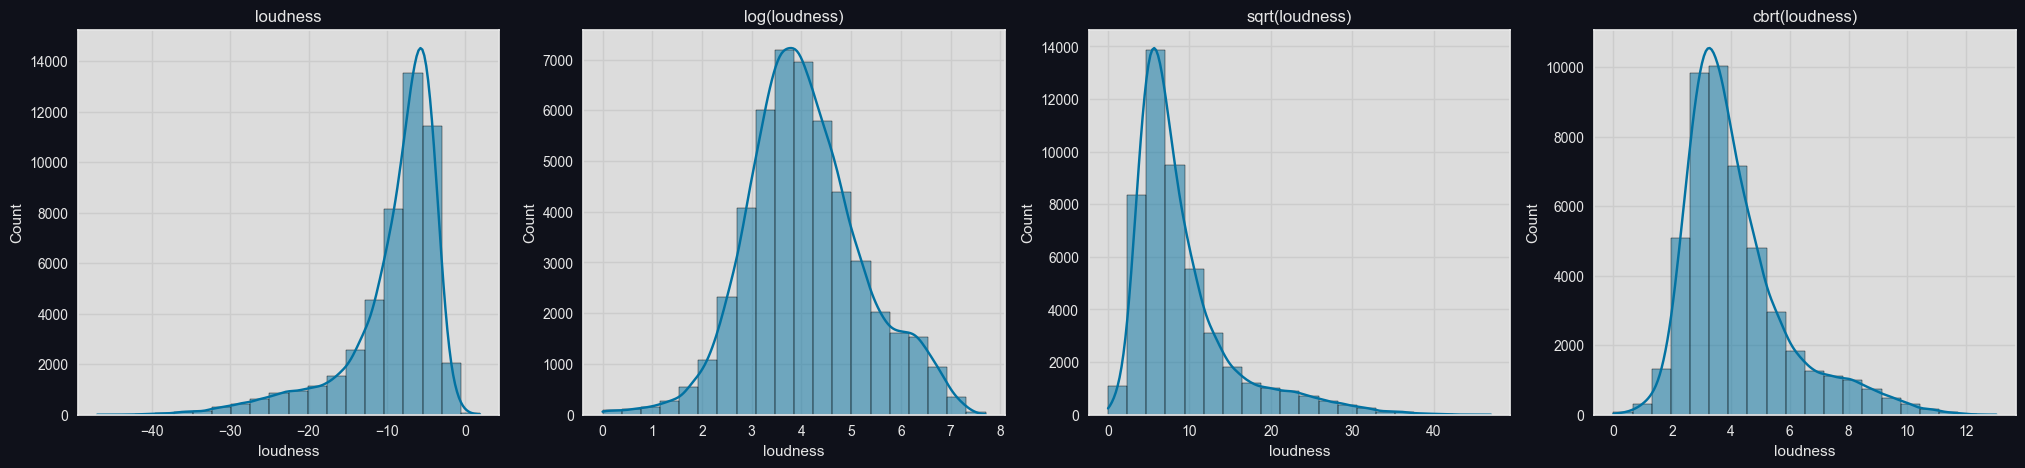

In [48]:
# Left skewed data can be transformed by taking the square first
loudness_base = df['loudness']
X = np.square(df["loudness"])
loudness_log = np.log(X+1)
loudness_sqrt = np.sqrt(X)
loudness_cbrt = np.cbrt(X)
title = ['loudness', 'log(loudness)', 'sqrt(loudness)', 'cbrt(loudness)']
loudnesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([loudness_base, loudness_log, loudness_sqrt, loudness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

In [49]:
dfLoudness = df.copy()
dfLoudness['loudness'] = loudness_log

modelBM_Loudness_log, resultBM_Loudness_log, confmatrixBM_Loudness_log, f1BM_Loudness_log = modelTestProcess(dfLoudness, getdummy=1)

Logistic Regression Model (F1 score) : 0.5380658637343865
Decision Tree Model (F1 score) : 0.44199705038660936
Random Forest Model (F1 score) : 0.5432208696618277
KNN Model (F1 score) : 0.47757514300049714
MLPC Model (F1 score) : 0.5846061770571997


#### **speechiness Feature**

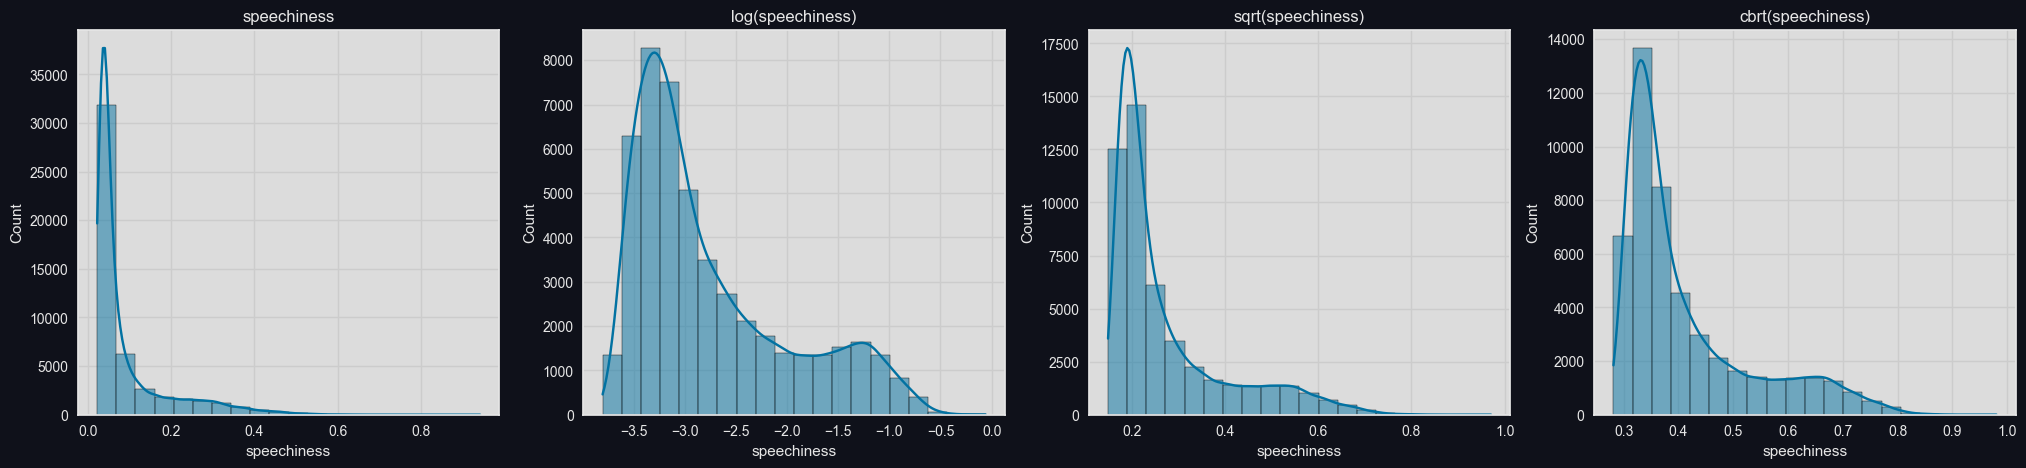

In [50]:
speechiness_base = df['speechiness']
speechiness_log = np.log(df["speechiness"])
speechiness_sqrt = np.sqrt(df["speechiness"])
speechiness_cbrt = np.cbrt(df["speechiness"])
title = ['speechiness', 'log(speechiness)', 'sqrt(speechiness)', 'cbrt(speechiness)']
speechinesstf , axes = plt.subplots(1, 4, figsize=(25, 5))
for idx, col in enumerate([speechiness_base, speechiness_log, speechiness_sqrt, speechiness_cbrt]):
    sns.histplot(col, ax=axes[idx], kde=True,bins=20)
    axes[idx].set_title(title[idx])

#### **Mix Feature**

In [51]:
dfMix = df.copy()
dfMix['duration_ms'] = duration_ms_log
dfMix['liveness'] = liveness_cbrt
dfMix['loudness'] = loudness_log

modelBM_Mix, resultBM_Mix, confmatrixBM_Mix, f1BM_Mix = modelTestProcess(dfMix, getdummy=1)

Logistic Regression Model (F1 score) : 0.5346875385993367
Decision Tree Model (F1 score) : 0.4423336541109584
Random Forest Model (F1 score) : 0.5431838161763447
KNN Model (F1 score) : 0.4737741259685333
MLPC Model (F1 score) : 0.5807543221261556


#### **Conclusion**

Not Good

### **Feature Scaling**

#### **Import Data**

In [52]:
df = pd.read_csv('Data/dfOutlier_res.csv')
dfNum = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence']
dfCate = ['key', 'mode']

In [53]:
df = pd.get_dummies(df, columns=['key','mode'],drop_first=True)
X = df.drop(['music_genre'], axis=1)
y = df['music_genre']

#### **StandardScaler**

In [54]:
Standardscaler = StandardScaler()
Xss = Standardscaler.fit_transform(X)
df_FE_SS = pd.DataFrame(Xss, columns=df.drop(['music_genre'], axis=1).columns)
df_FE_SS['music_genre'] = y
df_FE_SS

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor,music_genre
0,-1.131420,-0.880454,0.518825,0.226621,1.289310,1.888013,-0.481566,0.634848,-0.167852,-0.642721,...,-0.347066,-0.343513,-0.179567,-0.285741,-0.308871,-0.255542,-0.360714,-0.266626,1.335484,Electronic
1,-0.870287,-0.856916,0.349544,-0.269038,1.095733,2.374811,-0.424735,0.332545,-0.635823,-0.159905,...,-0.347066,2.911101,-0.179567,-0.285741,-0.308871,-0.255542,-0.360714,-0.266626,1.335484,Electronic
2,-1.066137,-0.885209,0.338258,-0.297081,0.583325,-0.515784,2.164250,0.730692,-0.588817,0.284560,...,-0.347066,-0.343513,-0.179567,-0.285741,-0.308871,-0.255542,-0.360714,3.750572,-0.748792,Electronic
3,-0.674436,-0.819642,1.207238,-0.807061,0.374566,-0.544345,-0.216353,0.750222,1.547347,0.285244,...,2.881298,-0.343513,-0.179567,-0.285741,-0.308871,-0.255542,-0.360714,-0.266626,-0.748792,Electronic
4,-0.805003,-0.880542,0.439827,-0.226388,-0.054339,2.248490,-0.216353,0.460063,-0.517786,0.867579,...,-0.347066,-0.343513,-0.179567,-0.285741,-0.308871,3.913245,-0.360714,-0.266626,-0.748792,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48495,0.957648,-0.796163,1.991576,-0.354324,-0.103682,-0.552140,-0.456308,0.335991,2.163648,-0.740598,...,2.881298,-0.343513,-0.179567,-0.285741,-0.308871,-0.255542,-0.360714,-0.266626,-0.748792,Hip-Hop
48496,1.806332,-0.433405,0.840461,0.082197,-0.908354,-0.552140,-0.519454,-0.122223,-0.374678,0.080972,...,-0.347066,-0.343513,-0.179567,-0.285741,-0.308871,-0.255542,-0.360714,-0.266626,-0.748792,Hip-Hop
48497,0.435381,-0.876668,0.750177,-0.570497,0.613690,-0.552140,-0.304757,0.595132,0.575888,0.390100,...,-0.347066,2.911101,-0.179567,-0.285741,-0.308871,-0.255542,-0.360714,-0.266626,-0.748792,Hip-Hop
48498,1.349348,-0.650296,1.252379,0.196388,-0.490836,-0.552140,-0.538397,0.665209,-0.488538,-1.498091,...,-0.347066,-0.343513,-0.179567,-0.285741,-0.308871,-0.255542,2.772279,-0.266626,1.335484,Hip-Hop


In [55]:
modelBM_FE_SS, resultBM_FE_SS, confmatrixBM_FE_SS, f1BM_FE_SS = modelTestProcess(df_FE_SS, getdummy=0)

Logistic Regression Model (F1 score) : 0.5357630309884516
Decision Tree Model (F1 score) : 0.4436429258486196
Random Forest Model (F1 score) : 0.5509369531669782
KNN Model (F1 score) : 0.4710736714570208
MLPC Model (F1 score) : 0.582190201113514


#### **MinMaxScaler**

In [56]:
MinMaxscaler = MinMaxScaler()
Xmm = MinMaxscaler.fit_transform(X)
df_FE_MM = pd.DataFrame(Xmm, columns=df.drop(['music_genre'], axis=1).columns)
df_FE_MM['music_genre'] = y
df_FE_MM

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor,music_genre
0,0.281250,0.004699,0.639309,0.129904,0.941896,0.795181,0.106358,0.854067,0.057084,0.362469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Electronic
1,0.322917,0.012751,0.606911,0.105225,0.890804,0.953815,0.115446,0.816471,0.008372,0.439345,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Electronic
2,0.291667,0.003072,0.604752,0.103829,0.755562,0.011847,0.529450,0.865986,0.013265,0.510115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Electronic
3,0.354167,0.025502,0.771058,0.078438,0.700463,0.002540,0.148769,0.868415,0.235620,0.510224,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Electronic
4,0.333333,0.004669,0.624190,0.107349,0.587260,0.912651,0.148769,0.832330,0.020659,0.602947,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48495,0.614583,0.033534,0.921166,0.100979,0.574237,0.000000,0.110398,0.816900,0.299772,0.346884,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hip-Hop
48496,0.750000,0.157631,0.700864,0.122713,0.361856,0.000000,0.100300,0.759914,0.035555,0.477699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hip-Hop
48497,0.531250,0.005994,0.683585,0.090216,0.763576,0.000000,0.134632,0.849127,0.134500,0.526920,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hip-Hop
48498,0.677083,0.083434,0.779698,0.128398,0.472054,0.000000,0.097271,0.857843,0.023703,0.226272,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Hip-Hop


In [57]:
modelBM_FE_MM, resultBM_FE_MM, confmatrixBM_FE_MM, f1BM_FE_MM = modelTestProcess(df_FE_MM, getdummy=0)

Logistic Regression Model (F1 score) : 0.5357630309884516
Decision Tree Model (F1 score) : 0.4436429258486196
Random Forest Model (F1 score) : 0.5509402128633895
KNN Model (F1 score) : 0.4709673156959691
MLPC Model (F1 score) : 0.582190201113514


#### **RobustScaler**

In [58]:
Robustscaler = RobustScaler()
Xrb = Robustscaler.fit_transform(X)
df_FE_RB = pd.DataFrame(Xrb, columns=df.drop(['music_genre'], axis=1).columns)
df_FE_RB['music_genre'] = y
df_FE_RB

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor,music_genre
0,-0.818182,-0.260520,0.337449,0.466024,0.782551,5.738134,-0.077356,0.363288,0.442211,-0.425942,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Electronic
1,-0.636364,-0.245304,0.213992,-0.119591,0.647720,6.883062,-0.014065,0.034535,-0.308208,-0.105202,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Electronic
2,-0.772727,-0.263593,0.205761,-0.152723,0.290813,0.084511,2.869198,0.467517,-0.232831,0.190063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Electronic
3,-0.500000,-0.221210,0.839506,-0.755258,0.145406,0.017337,0.218003,0.488756,3.192630,0.190517,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Electronic
4,-0.590909,-0.260577,0.279835,-0.069200,-0.153338,6.585960,0.218003,0.173211,-0.118928,0.577370,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48495,0.636364,-0.206033,1.411523,-0.220355,-0.187707,-0.000996,-0.049226,0.038283,4.180905,-0.490963,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hip-Hop
48496,1.227273,0.028458,0.572016,0.295389,-0.748182,-0.000996,-0.119550,-0.460021,0.110553,0.054817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hip-Hop
48497,0.272727,-0.258072,0.506173,-0.475761,0.311963,-0.000996,0.119550,0.320096,1.634841,0.260174,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hip-Hop
48498,0.909091,-0.111744,0.872428,0.430304,-0.457369,-0.000996,-0.140647,0.396306,-0.072027,-0.994176,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Hip-Hop


In [59]:
modelBM_FE_RB, resultBM_FE_RB, confmatrixBM_FE_RB, f1BM_FE_RB = modelTestProcess(df_FE_RB, getdummy=0)

Logistic Regression Model (F1 score) : 0.5357630309884516
Decision Tree Model (F1 score) : 0.4436429258486196
Random Forest Model (F1 score) : 0.5509402128633895
KNN Model (F1 score) : 0.4710736714570208
MLPC Model (F1 score) : 0.582190201113514


#### **Conclusion**

Look the same so we pick StandardScaler

In [60]:
df_FE_SS.to_csv('Data/df_FE_SS.csv', index=False)

### **Feature Extraction**

In [61]:
def checkCorrFF(df, figw, figh):
    corr, ax = plt.subplots(1, 1, figsize=(figw, figh))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap='inferno', ax=ax)
    return corr

#### **Import Data**

In [62]:
df = pd.read_csv('Data/df_FE_SS.csv')
dfNum = ['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence']
dfCate = ['key', 'mode']
X = df.drop(['music_genre'], axis=1)
y = df['music_genre']
y_vis = y.replace({'Electronic':0, 'Anime':1, 'Jazz':2, 'Alternative':3, 'Country':4, 'Rap':5, 'Blues':6, 'Rock':7, 'Classical':8, 'Hip-Hop':9})
dfvis = pd.DataFrame(X, columns=df.drop(['music_genre'], axis=1).columns)
dfvis['music_genre'] = y_vis

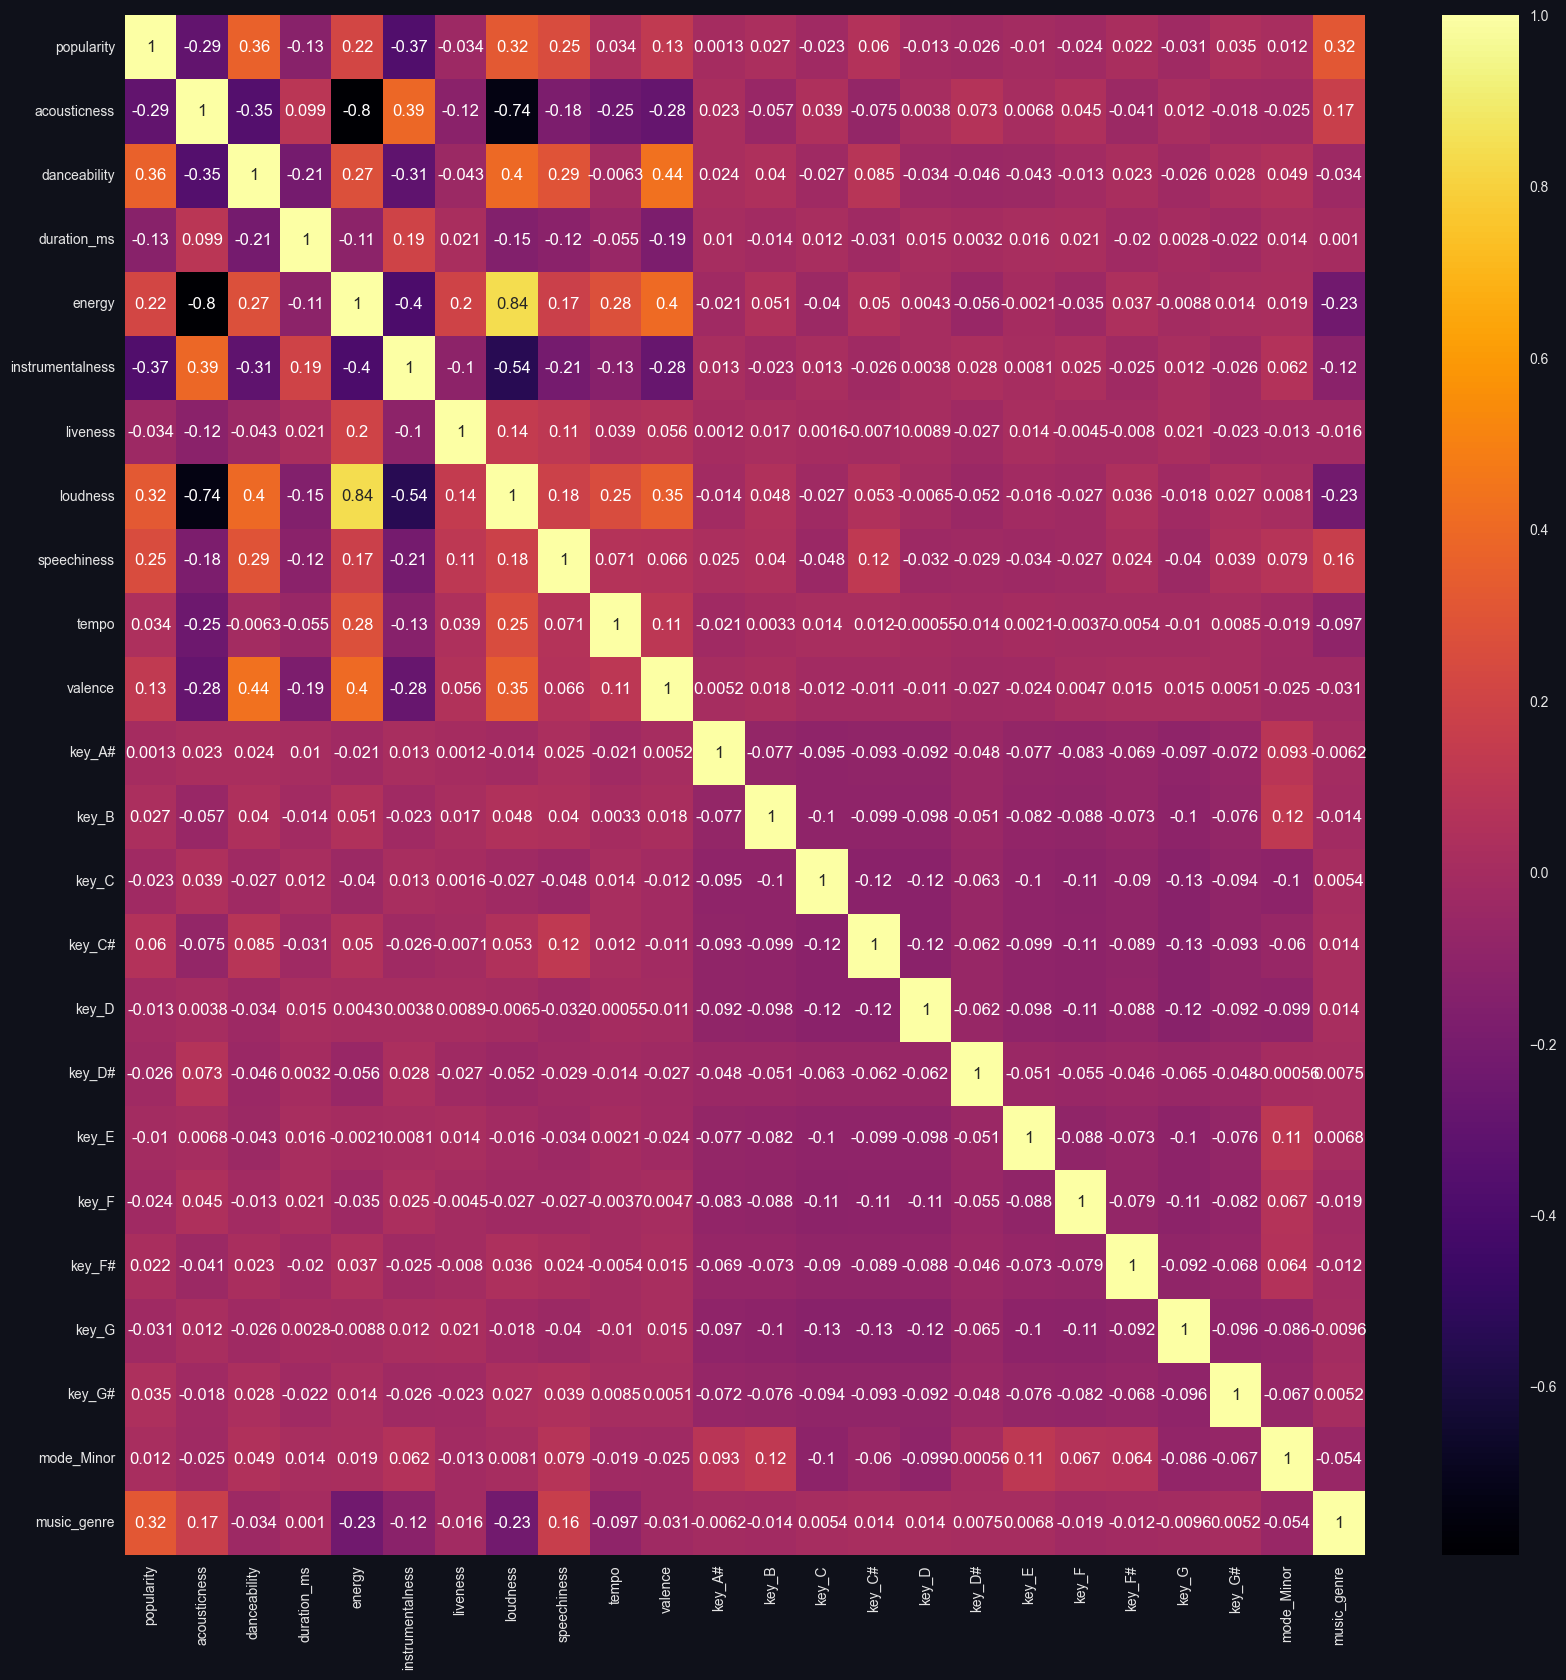

In [63]:
scaledFECorr = checkCorrFF(dfvis, 20, 20)

#### **ANOVA**

We will be using ANOVA to select the best features from the dataset because our dataset is both categorical and numerical.

In [64]:
def anovaSelector(df,k:list=['Default'],verbose:int=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    dfa = df.copy()
    if k == ['Default']:
        k = [int(len(dfa.columns)/2)]
    print(f'Start ANOVA feature selection with k={k}')
    # Split the data into X and y
    X = dfa.drop(['music_genre'], axis=1)
    y = dfa['music_genre']
    y_vis = y.replace({'Electronic':0, 'Anime':1, 'Jazz':2, 'Alternative':3, 'Country':4, 'Rap':5, 'Blues':6, 'Rock':7, 'Classical':8, 'Hip-Hop':9})
    # Create Buffer
    bestmodel = {
        "Logistic Regression Model" : None,
        "Decision Tree Model" : None,
        "Random Forest Model" : None,
        "KNN Model" : None,
        "MLPC Model" : None,
    }
    bestresult = {
        "Logistic Regression Model" : 0,
        "Decision Tree Model" : 0,
        "Random Forest Model" : 0,
        "KNN Model" : 0,
        "MLPC Model" : 0,   
    }
    bestK = {
        "Logistic Regression Model" : 0,
        "Decision Tree Model" : 0,
        "Random Forest Model" : 0,
        "KNN Model" : 0,
        "MLPC Model" : 0,
    }
    iteration = 0
    for idx in k:
        verboseprint(f'Number of features: {idx}')
        anova_filter = SelectKBest(f_classif, k=idx)
        anova_filter.fit_transform(X, y)
        anova_support = anova_filter.get_support(indices=True)
        dfanova_select = dfa.iloc[:,anova_support]
        dfanova_select['music_genre'] = y
        verboseprint(f'Features selected: {dfanova_select.columns}')
        verboseprint(f'Star training model...')
        model, result, confmatrix, f1 = modelTestProcess(dfanova_select, getdummy=0)
        for key in bestmodel:
            if f1[key] > bestresult[key]:
                bestmodel[key] = model[key]
                bestresult[key] = f1[key]
                bestK[key] = idx
        iteration += 1
        verboseprint(f'Iteration {iteration} Best K: {bestK}')
        verboseprint('-'*50)
    return bestmodel, bestresult, bestK

In [65]:
'''
Number of features: 9
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'valence',
       'music_genre'],
      dtype='object')
Star training model
Logistic Regression Model (F1 score) : 0.5260571212943834
Decision Tree Model (F1 score) : 0.44154561159716826
Random Forest Model (F1 score) : 0.5425811891527921
KNN Model (F1 score) : 0.504160146149043
MLPC Model (F1 score) : 0.587763613712681
Iteration 1 Best K: {'Logistic Regression Model': 9, 'Decision Tree Model': 9, 'Random Forest Model': 9, 'KNN Model': 9, 'MLPC Model': 9}
--------------------------------------------------
Number of features: 10
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence',
       'music_genre'],
      dtype='object')
Star training model
Logistic Regression Model (F1 score) : 0.5277950778264864
Decision Tree Model (F1 score) : 0.438809854408412
Random Forest Model (F1 score) : 0.5506617999318845
KNN Model (F1 score) : 0.5046126888471603
MLPC Model (F1 score) : 0.5915947995749494
Iteration 2 Best K: {'Logistic Regression Model': 10, 'Decision Tree Model': 9, 'Random Forest Model': 10, 'KNN Model': 10, 'MLPC Model': 10}
--------------------------------------------------
Number of features: 11
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence',
       'mode_Minor', 'music_genre'],
      dtype='object')
Star training model
Logistic Regression Model (F1 score) : 0.532093182483687
Decision Tree Model (F1 score) : 0.4446852810651243
Random Forest Model (F1 score) : 0.5550049476008895
KNN Model (F1 score) : 0.5062018016528687
MLPC Model (F1 score) : 0.5942121258113638
Iteration 3 Best K: {'Logistic Regression Model': 11, 'Decision Tree Model': 11, 'Random Forest Model': 11, 'KNN Model': 11, 'MLPC Model': 11}
--------------------------------------------------
Number of features: 12
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence',
       'key_C#', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model
Logistic Regression Model (F1 score) : 0.5310457268457894
Decision Tree Model (F1 score) : 0.4425950704036651
Random Forest Model (F1 score) : 0.5549577861259054
KNN Model (F1 score) : 0.5011539964456009
MLPC Model (F1 score) : 0.5902917593600937
Iteration 4 Best K: {'Logistic Regression Model': 11, 'Decision Tree Model': 11, 'Random Forest Model': 11, 'KNN Model': 11, 'MLPC Model': 11}
--------------------------------------------------
Number of features: 13
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_C#', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model
Logistic Regression Model (F1 score) : 0.5305672893274366
Decision Tree Model (F1 score) : 0.43822852867113576
Random Forest Model (F1 score) : 0.555449972467583
KNN Model (F1 score) : 0.5014106517249948
MLPC Model (F1 score) : 0.5936132129473269
Iteration 5 Best K: {'Logistic Regression Model': 11, 'Decision Tree Model': 11, 'Random Forest Model': 13, 'KNN Model': 11, 'MLPC Model': 11}
--------------------------------------------------
Number of features: 14
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_A#', 'key_C#', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model
Logistic Regression Model (F1 score) : 0.5324330539715113
Decision Tree Model (F1 score) : 0.44193007791288813
Random Forest Model (F1 score) : 0.5530720742345434
KNN Model (F1 score) : 0.4974259349081127
MLPC Model (F1 score) : 0.5928478752509595
Iteration 4 Best K: {'Logistic Regression Model': 14, 'Decision Tree Model': 11, 'Random Forest Model': 13, 'KNN Model': 11, 'MLPC Model': 11}
--------------------------------------------------
Number of features: 15
Features selected: Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_A#', 'key_C#', 'key_D', 'mode_Minor', 'music_genre'],
      dtype='object')
Star training model
Logistic Regression Model (F1 score) : 0.5334196031320028
Decision Tree Model (F1 score) : 0.44116432627121743
Random Forest Model (F1 score) : 0.5524100941488908
KNN Model (F1 score) : 0.49499465997695213
MLPC Model (F1 score) : 0.5940271780921657
Iteration 5 Best K: {'Logistic Regression Model': 15, 'Decision Tree Model': 11, 'Random Forest Model': 13, 'KNN Model': 11, 'MLPC Model': 11}
--------------------------------------------------
'''
# anovamodel, anovaresult, anovaK = anovaSelector(df,k = [9,10,11,12,13],verbose=1)
pass

เนื่องจากคะแนนที่ได้จากการทำ Benchmark ด้วย ANOVA ที่เลือก Feature ที่มีค่าค่อนข้างสูงที่ K = 11 โดยหากมากกว่านั้นจะมีบาง Model ที่มีคะแนนเพิ่มมากขึ้น แต่เพิ่มขึ้นค่อนข้างน้อยมากดังนั้นแล้วเราจะเลือก K = 11 เพื่อให้ Model ที่ได้มีความแม่นและลด Overfitting ของ Model ลง (เนื่องจากจำนวน Feature ที่เหลือน้อยลง)

In [66]:
selector = SelectKBest(f_classif, k=11)
Xselect = selector.fit(X, y)
col = Xselect.get_support(indices=True)
dfSelect = df.iloc[:,col]
dfSelect['music_genre'] = y
dfSelect

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,speechiness,tempo,valence,mode_Minor,music_genre
0,-1.131420,-0.880454,0.518825,0.226621,1.289310,1.888013,0.634848,-0.167852,-0.642721,1.228594,1.335484,Electronic
1,-0.870287,-0.856916,0.349544,-0.269038,1.095733,2.374811,0.332545,-0.635823,-0.159905,0.301420,1.335484,Electronic
2,-1.066137,-0.885209,0.338258,-0.297081,0.583325,-0.515784,0.730692,-0.588817,0.284560,-0.503758,-0.748792,Electronic
3,-0.674436,-0.819642,1.207238,-0.807061,0.374566,-0.544345,0.750222,1.547347,0.285244,-0.759951,-0.748792,Electronic
4,-0.805003,-0.880542,0.439827,-0.226388,-0.054339,2.248490,0.460063,-0.517786,0.867579,-0.544423,-0.748792,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...
48495,0.957648,-0.796163,1.991576,-0.354324,-0.103682,-0.552140,0.335991,2.163648,-0.740598,-0.515958,-0.748792,Hip-Hop
48496,1.806332,-0.433405,0.840461,0.082197,-0.908354,-0.552140,-0.122223,-0.374678,0.080972,-1.398400,-0.748792,Hip-Hop
48497,0.435381,-0.876668,0.750177,-0.570497,0.613690,-0.552140,0.595132,0.575888,0.390100,-0.251632,-0.748792,Hip-Hop
48498,1.349348,-0.650296,1.252379,0.196388,-0.490836,-0.552140,0.665209,-0.488538,-1.498091,-0.418360,1.335484,Hip-Hop


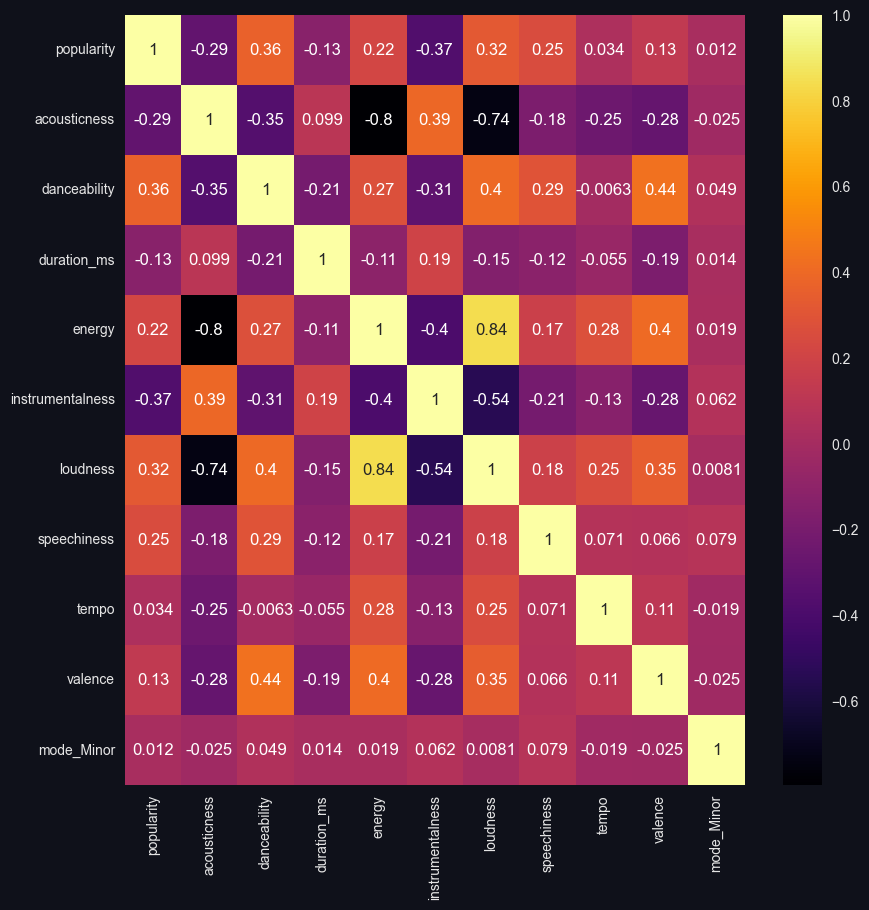

In [67]:
anova11 = checkCorrFF(dfSelect, 10, 10)

In [68]:
dfSelect.columns

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence',
       'mode_Minor', 'music_genre'],
      dtype='object')

โดย Feature ที่ถูกตัดออกจาก Dataset จะมีข้อสังเกตดังนี้ดังนี้

In [69]:
df = pd.read_csv('Data/dfOutlier_res.csv')
Xcat = pd.get_dummies(df.drop(['music_genre'],axis=1),drop_first=True)
Xcat = Xcat[['key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#',
       'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'mode_Minor',]]
Xcat

,key_A#,key_B,key_C,key_C#,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,mode_Minor
0,1,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48495,0,0,0,1,0,0,0,0,0,0,0,0
48496,0,1,0,0,0,0,0,0,0,0,0,0
48497,0,0,0,0,1,0,0,0,0,0,0,0
48498,0,0,0,0,0,0,0,0,0,1,0,1


In [70]:
dfXCat = pd.concat([Xcat,df['music_genre']],axis=1)
dfCateDict = {"Electronic": dfXCat.groupby('music_genre').get_group('Hip-Hop'),
            "Anime": dfXCat.groupby('music_genre').get_group('Anime'),
            "Jazz": dfXCat.groupby('music_genre').get_group('Jazz'),
            "Alternative": dfXCat.groupby('music_genre').get_group('Alternative'),
            "Country": dfXCat.groupby('music_genre').get_group('Country'),
            "Rap": dfXCat.groupby('music_genre').get_group('Rap'),
            "Blues": dfXCat.groupby('music_genre').get_group('Blues'),
            "Rock": dfXCat.groupby('music_genre').get_group('Rock'),
            "Classical": dfXCat.groupby('music_genre').get_group('Classical'),
            "Hip-Hop": dfXCat.groupby('music_genre').get_group('Hip-Hop'),
}

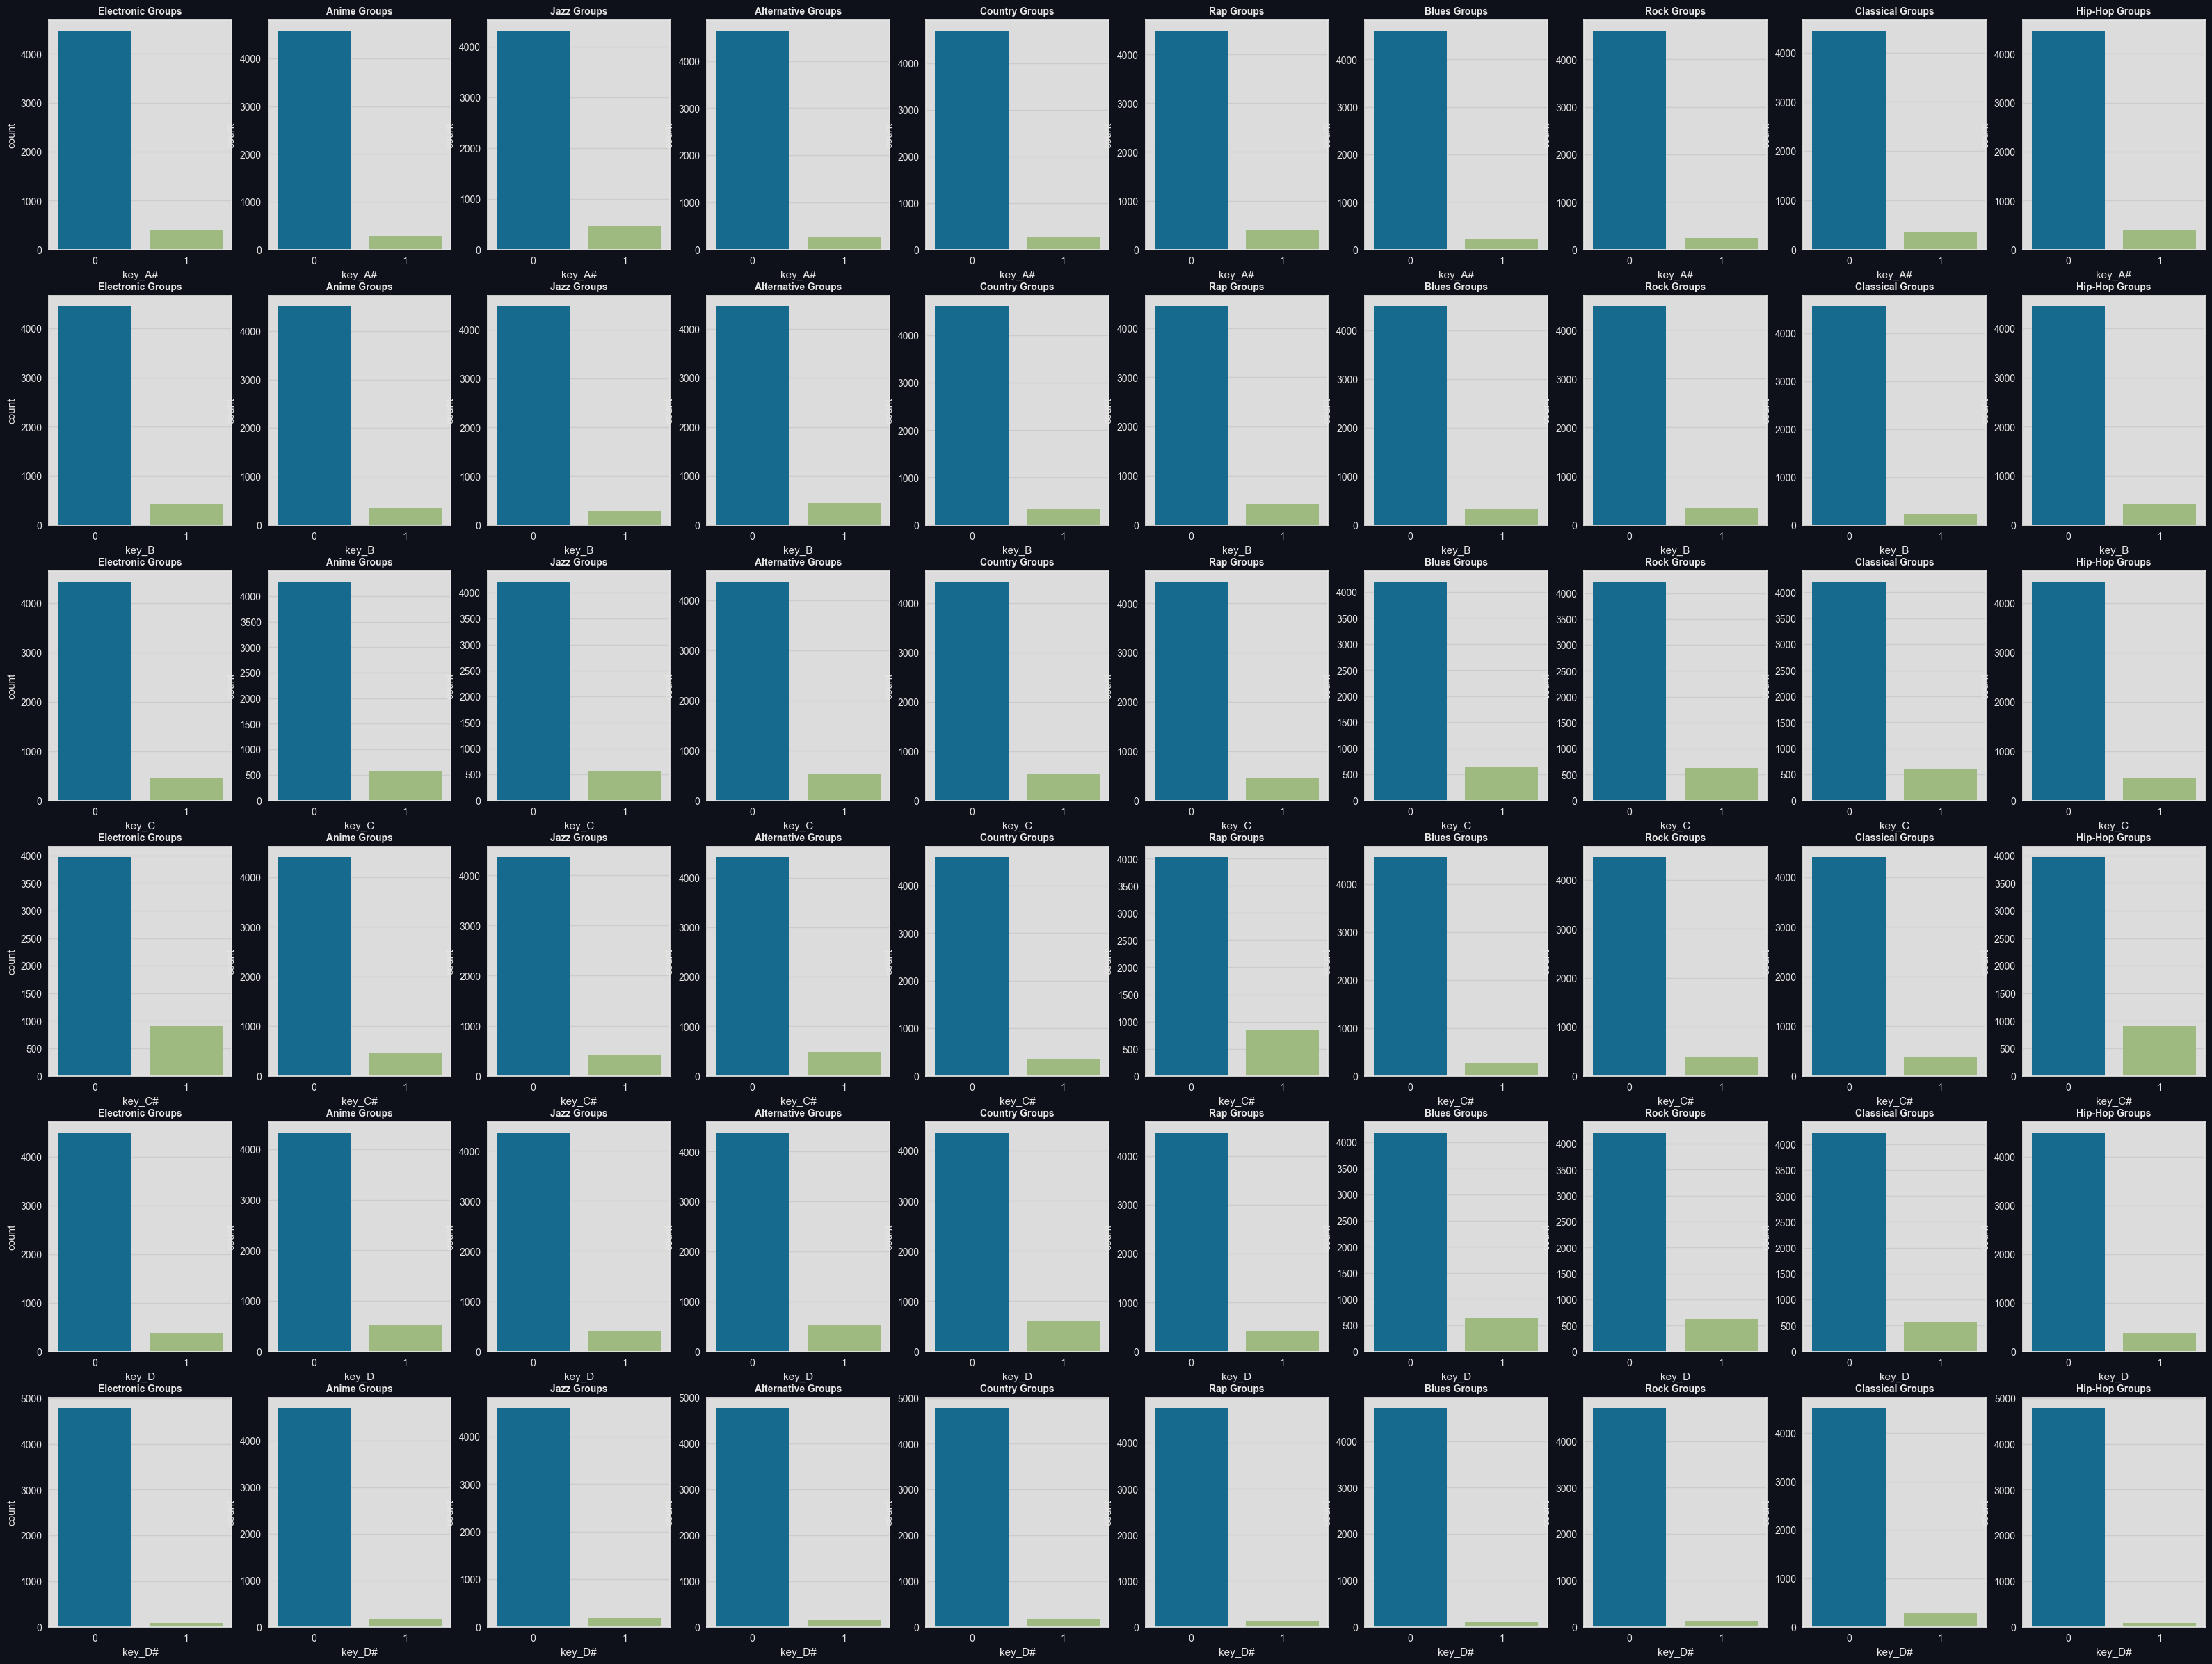

In [71]:
catcol = ['key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#',]
catVisPlot , axes = plt.subplots( len(catcol),10, figsize=(40, 30))
count = 0
for key, item in dfCateDict.items():
    for idx,col in enumerate(catcol):
        ax = axes[idx,count]
        sns.countplot(x=col, data=item, ax=ax)
        ax.set_title(f'{key} Groups', weight='bold', fontsize=10)
    count += 1

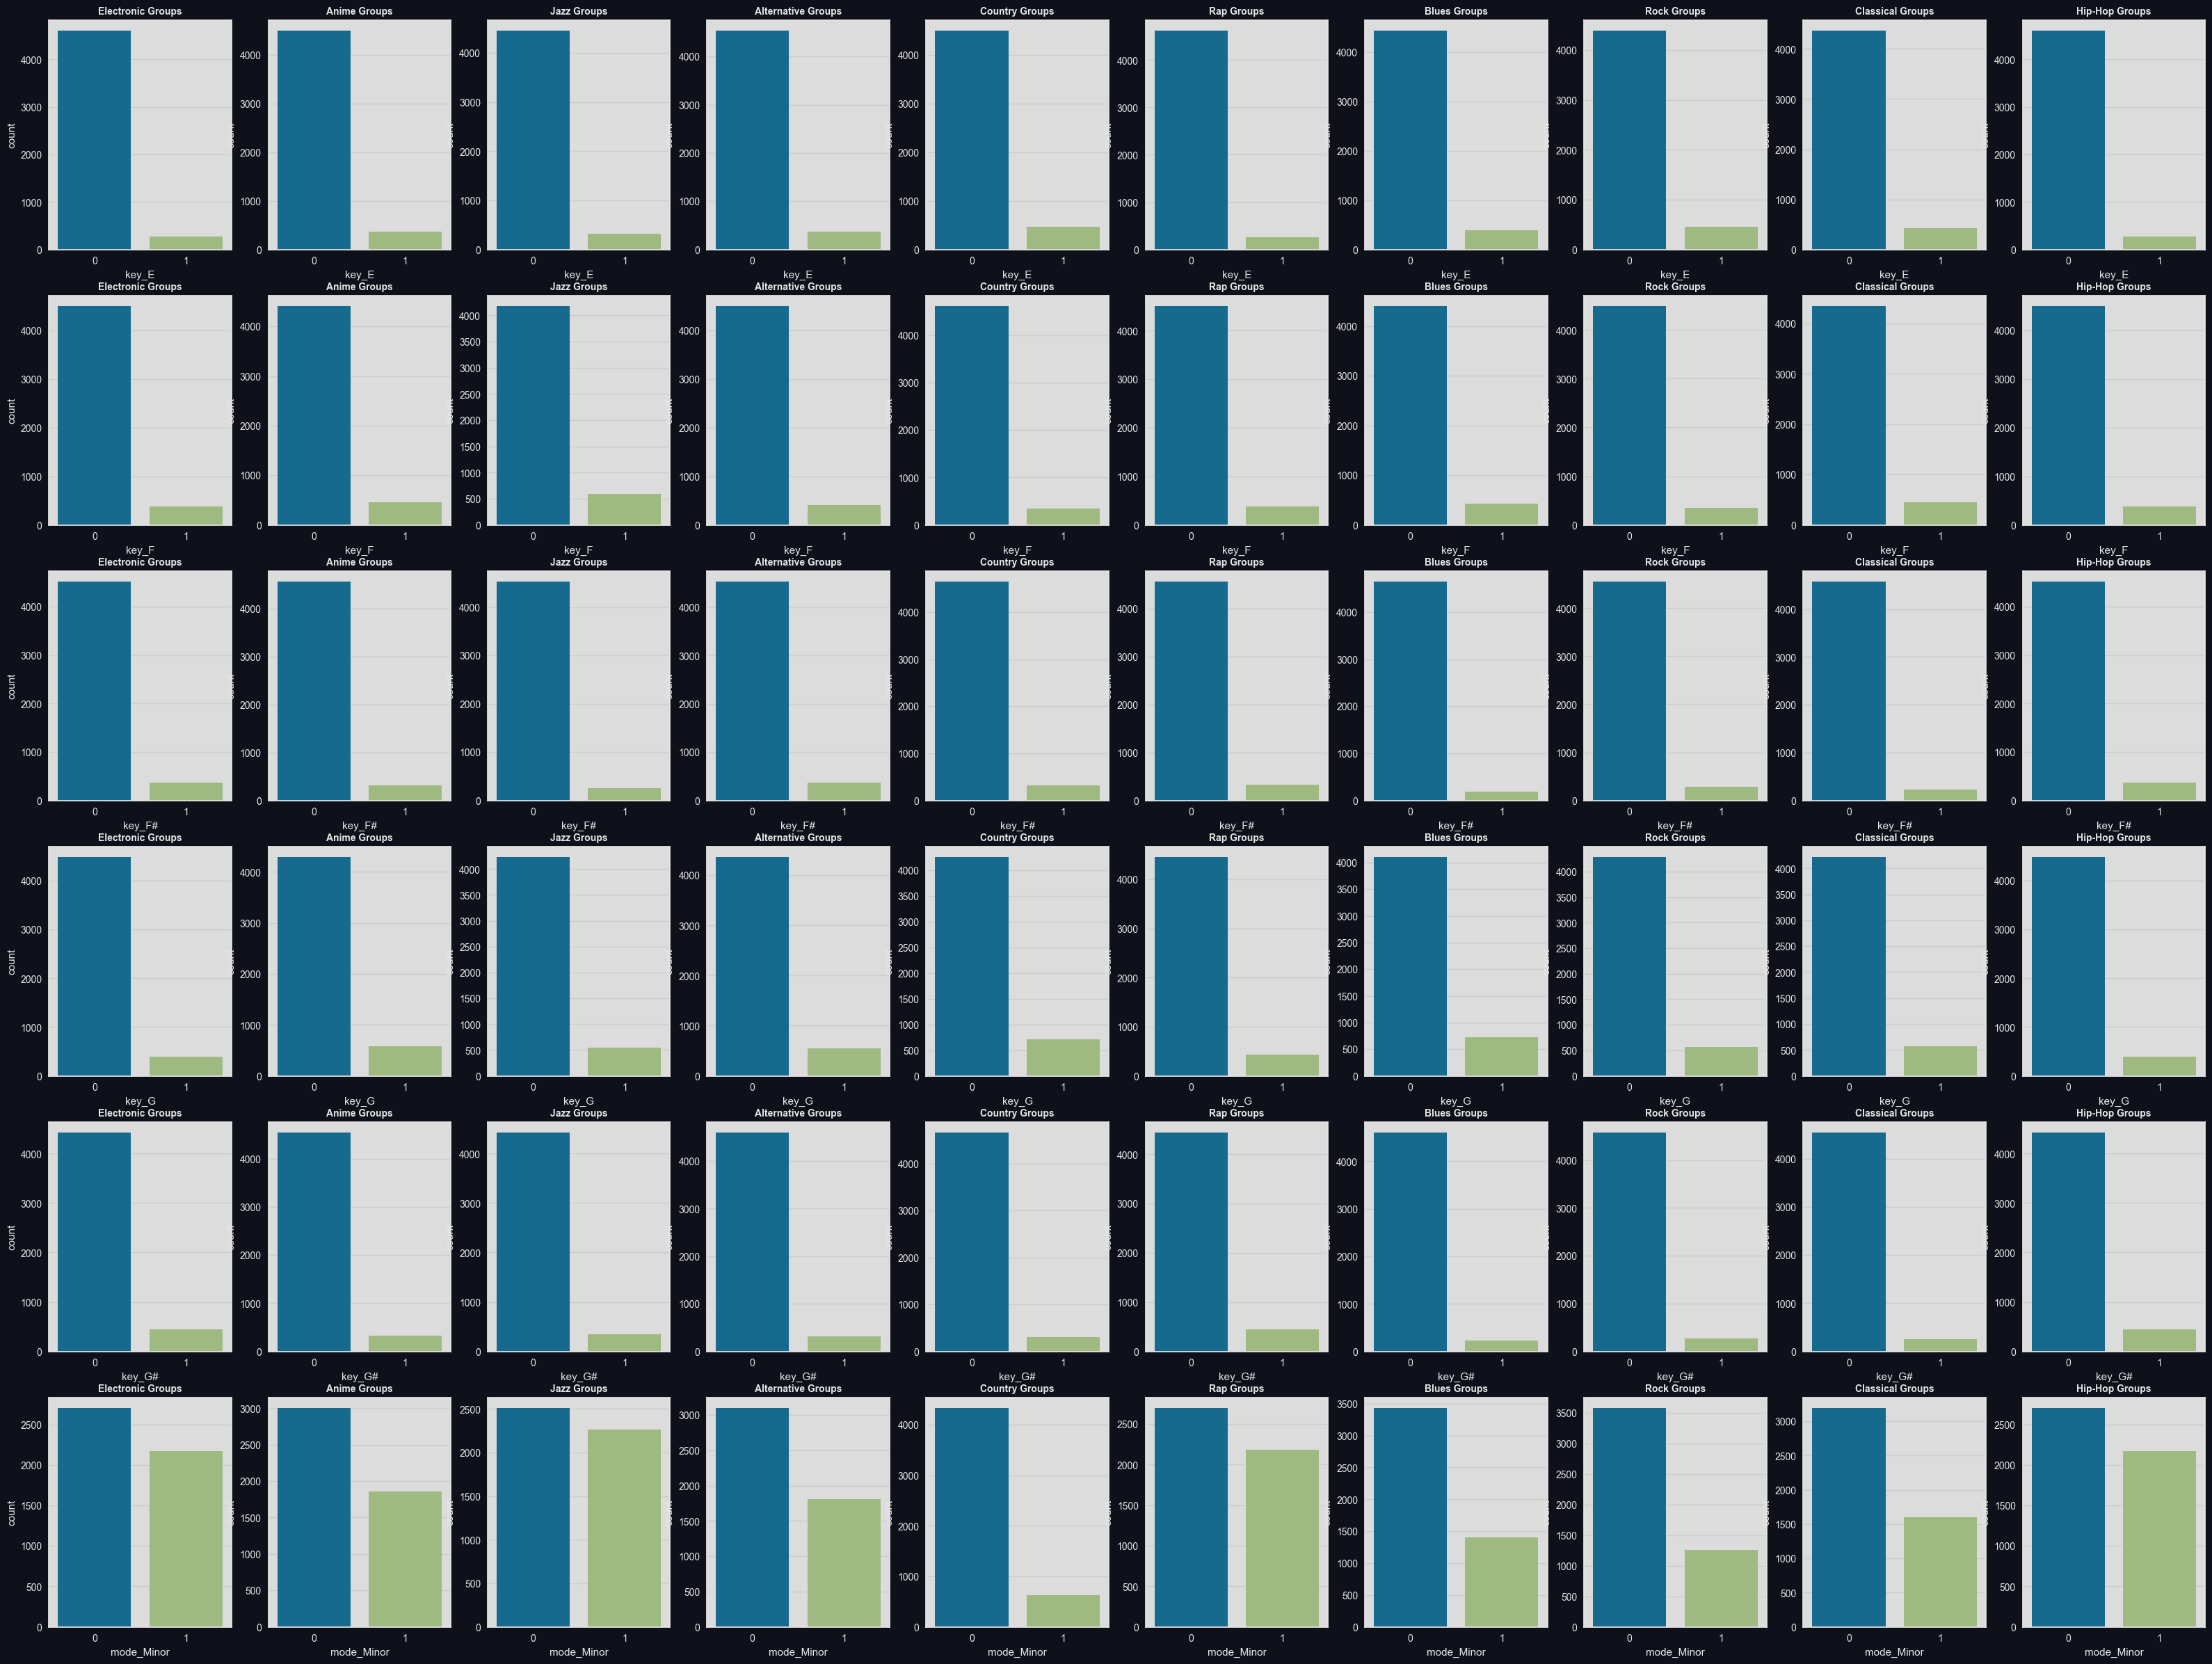

In [72]:
catcol = ['key_E', 'key_F', 'key_F#', 'key_G', 'key_G#', 'mode_Minor',]
catVisPlot , axes = plt.subplots( len(catcol),10, figsize=(40, 30))
count = 0
for key, item in dfCateDict.items():
    for idx,col in enumerate(catcol):
        ax = axes[idx,count]
        sns.countplot(x=col, data=item, ax=ax)
        ax.set_title(f'{key} Groups', weight='bold', fontsize=10)
    count += 1

In [73]:
selectorChi2 = SelectKBest(chi2, k=3)
XcatSelected = selectorChi2.fit_transform(Xcat, df['music_genre'])
colcat = selectorChi2.get_support(indices=True)
Xcat = Xcat.iloc[:,colcat]
catcol = Xcat.columns
Xcat['music_genre'] = df['music_genre']
Xcat

,key_A#,key_C#,mode_Minor,music_genre
0,1,0,1,Electronic
1,0,0,1,Electronic
2,0,0,0,Electronic
3,0,1,0,Electronic
4,0,0,0,Electronic
...,...,...,...,...
48495,0,1,0,Hip-Hop
48496,0,0,0,Hip-Hop
48497,0,0,0,Hip-Hop
48498,0,0,1,Hip-Hop


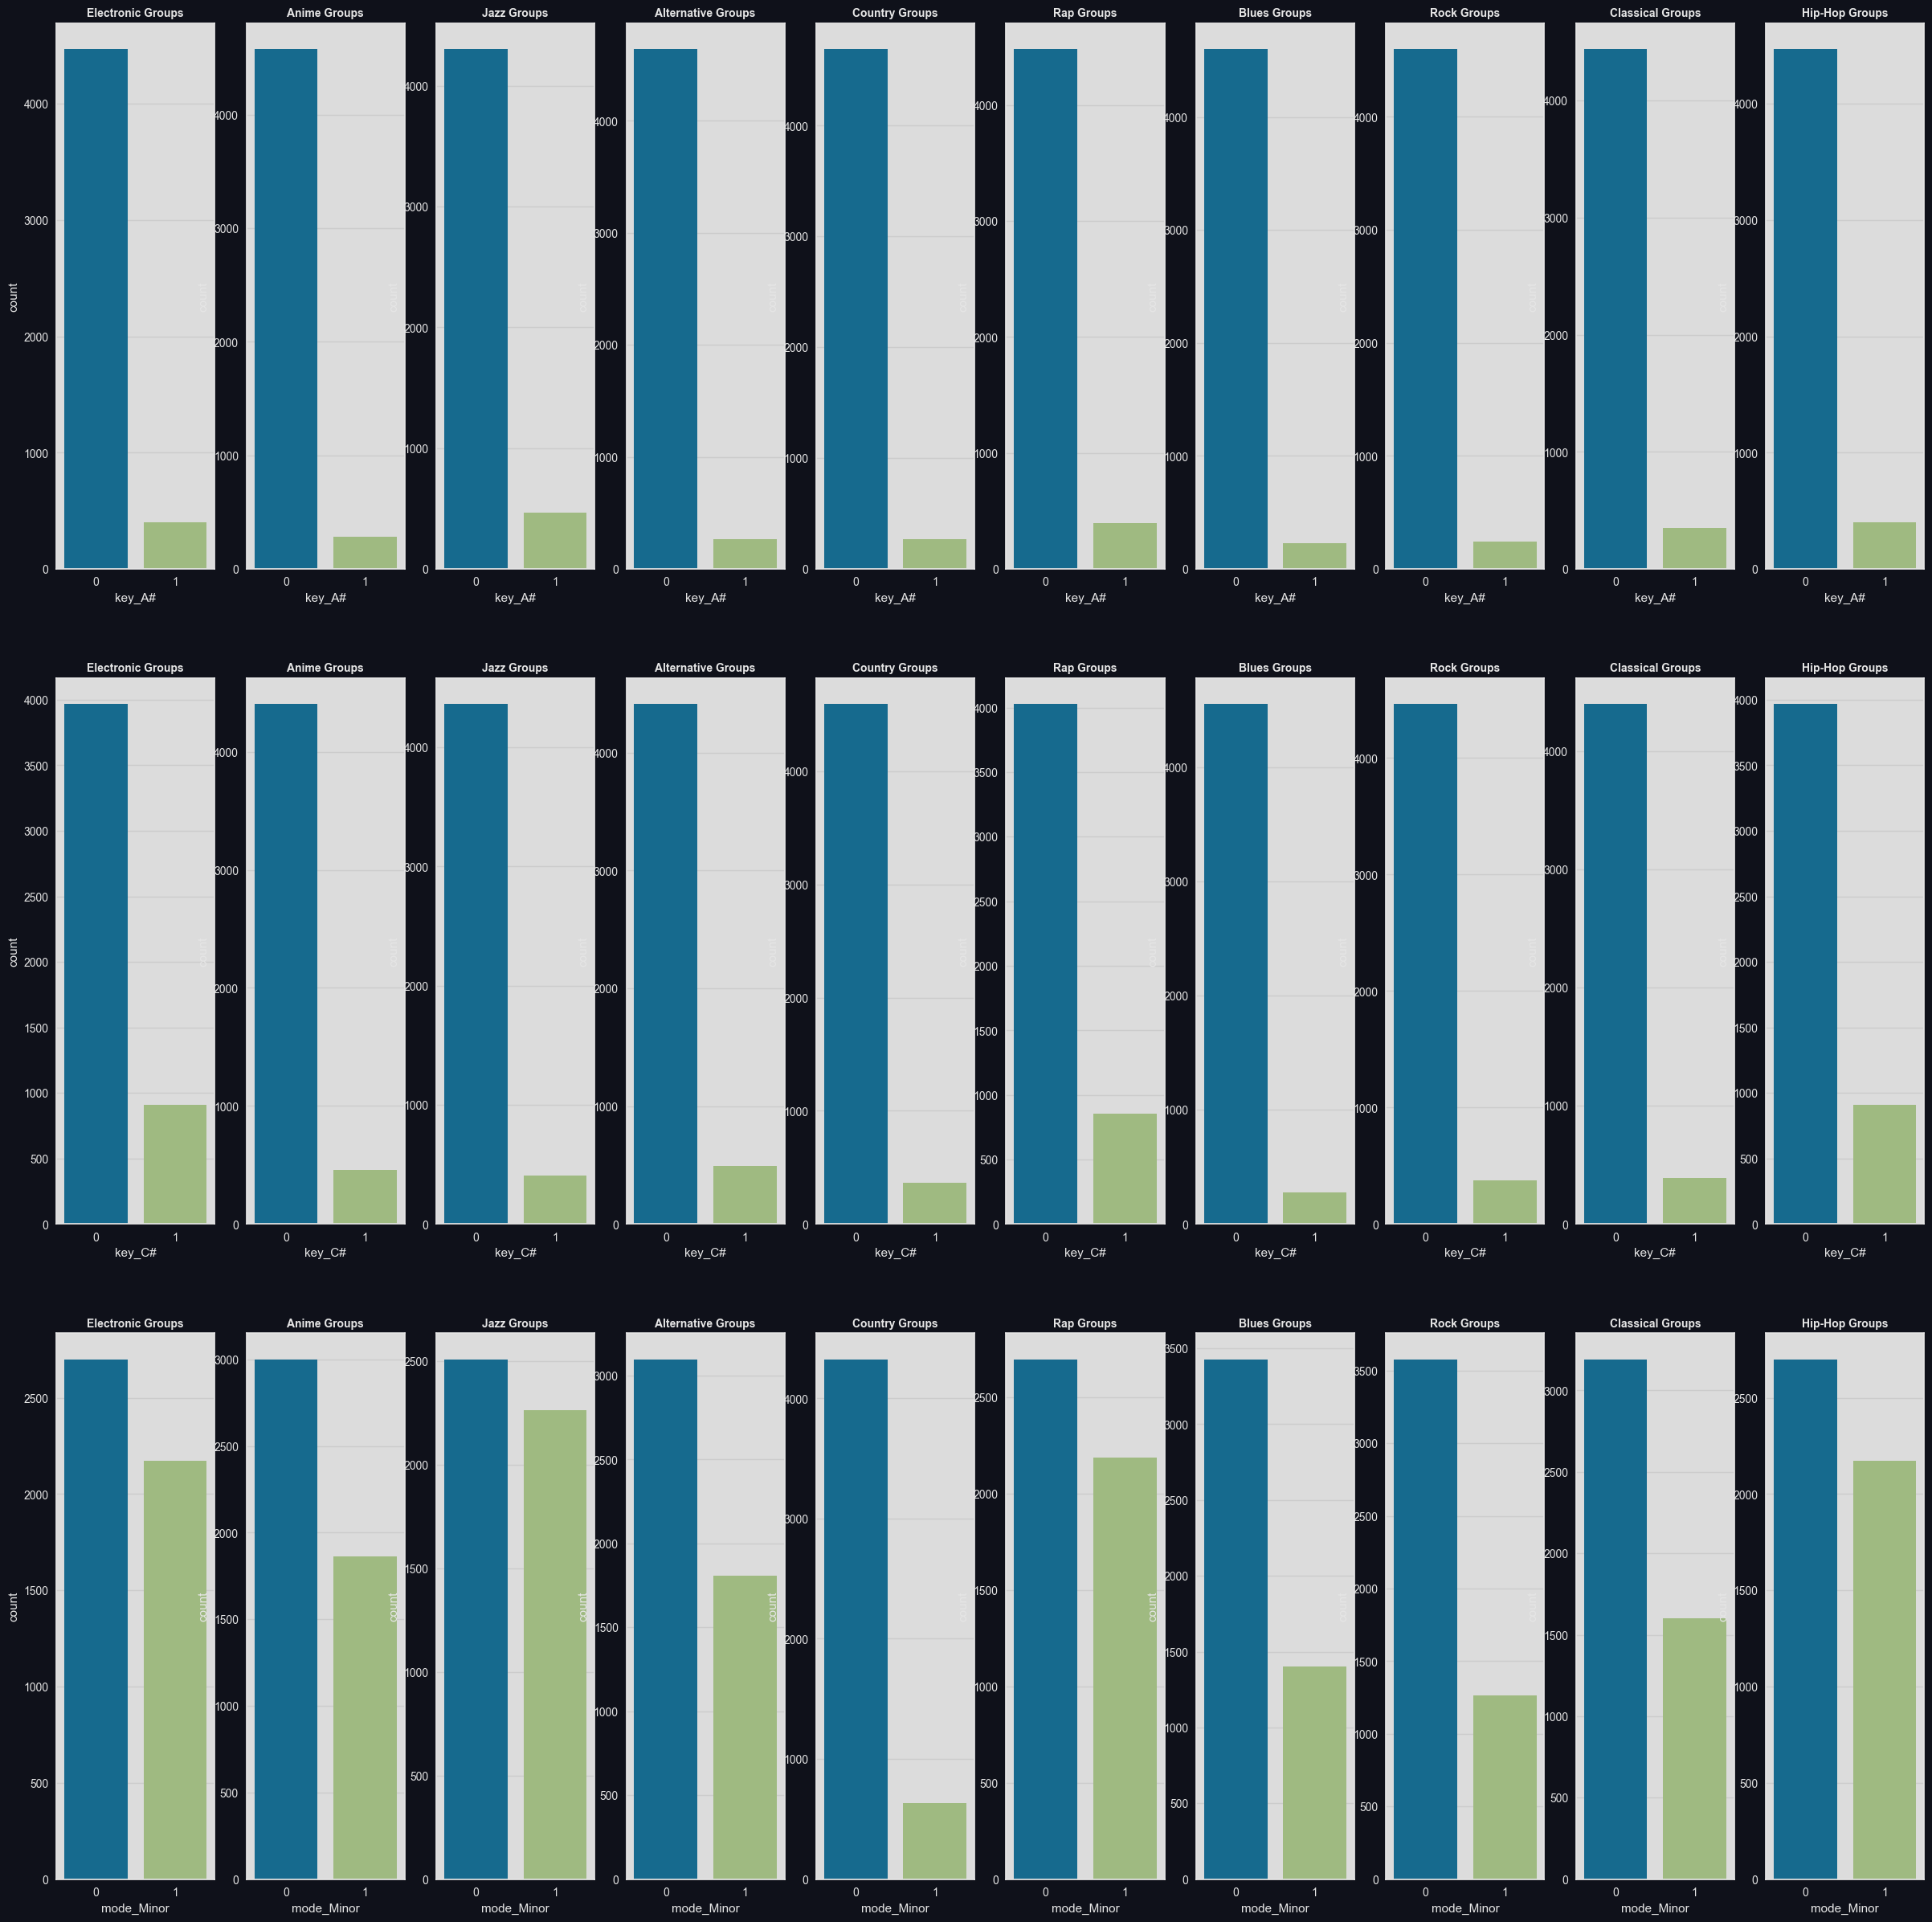

In [74]:
dfCateDict = {"Electronic": Xcat.groupby('music_genre').get_group('Hip-Hop'),
            "Anime": Xcat.groupby('music_genre').get_group('Anime'),
            "Jazz": Xcat.groupby('music_genre').get_group('Jazz'),
            "Alternative": Xcat.groupby('music_genre').get_group('Alternative'),
            "Country": Xcat.groupby('music_genre').get_group('Country'),
            "Rap": Xcat.groupby('music_genre').get_group('Rap'),
            "Blues": Xcat.groupby('music_genre').get_group('Blues'),
            "Rock": Xcat.groupby('music_genre').get_group('Rock'),
            "Classical": Xcat.groupby('music_genre').get_group('Classical'),
            "Hip-Hop": Xcat.groupby('music_genre').get_group('Hip-Hop'),
}
catVisPlot , axes = plt.subplots( len(catcol), 10, figsize=(30, 30))
count = 0
for key, item in dfCateDict.items():
    for idx,col in enumerate(catcol):
        ax = axes[idx,count]
        sns.countplot(x=col, data=item, ax=ax)
        ax.set_title(f'{key} Groups', weight='bold', fontsize=10)
    count += 1

##### **Performance**

In [75]:
dfSelect['music_genre'] = y

modelBM_Select, resultBM_Select, confmatrixBM_Select, f1BM_Select = modelTestProcess(dfSelect, getdummy=0)

Logistic Regression Model (F1 score) : 0.532093182483687
Decision Tree Model (F1 score) : 0.4446852810651243
Random Forest Model (F1 score) : 0.5550049476008895
KNN Model (F1 score) : 0.5062018016528687
MLPC Model (F1 score) : 0.5942121258113638


#### **Feature Drop Experiment**

In [76]:
dfSelectD = dfSelect.copy()
dfSelectD = dfSelectD.drop(['loudness','energy'], axis=1)
dfSelectD.columns

Index(['popularity', 'acousticness', 'danceability', 'duration_ms',
       'instrumentalness', 'speechiness', 'tempo', 'valence', 'mode_Minor',
       'music_genre'],
      dtype='object')

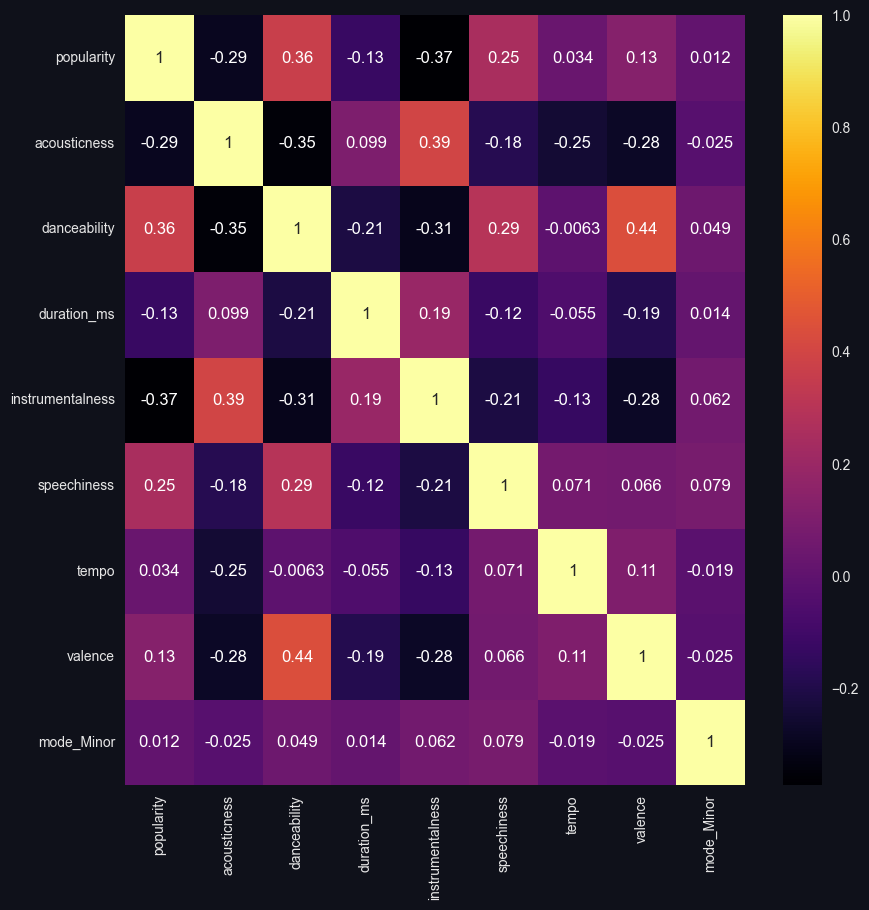

In [77]:
SelectD = checkCorrFF(dfSelectD, 10, 10)

##### **Performance**

In [78]:
modelBM_SelectD, resultBM_SelectD, confmatrixBM_SelectD, f1BM_SelectD = modelTestProcess(dfSelectD, getdummy=0)

Logistic Regression Model (F1 score) : 0.5103183111731755
Decision Tree Model (F1 score) : 0.43916640296903087
Random Forest Model (F1 score) : 0.5406180246544385
KNN Model (F1 score) : 0.49100938385003245
MLPC Model (F1 score) : 0.572626627955503


#### **Principal Component Analysis (PCA)**

In [79]:
def dfPCAGenerator(df, threshold,verbose:int=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    dfPCA = df.copy()
    pca = PCA(n_components = len(dfPCA.columns))           
    pca.fit_transform(dfPCA)          

    # Print the explained variance ratio
    verboseprint('Number of components: ', pca.n_components_)
    verboseprint(f'Variace list: {pca.explained_variance_ratio_}')
    for i in range(len(pca.explained_variance_ratio_)):
        verboseprint('PC', i+1, ': ', np.around(pca.explained_variance_ratio_[i],4), ' (', np.around(sum(pca.explained_variance_ratio_[0:i+1]),4), ')')
    
    # Select the number of components where the variance is above the threshold
    varThreshold = threshold
    var = np.where(pca.explained_variance_ratio_.cumsum() >= varThreshold)[0][0] +1
    realVar = pca.explained_variance_ratio_.cumsum()[var-1]
    print(f'Number of components to explain {realVar*100}% of variance: {var}')
    
    # Plot the explained variance ratio
    if verbose == 1:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        for i in range(0, len(pca.explained_variance_ratio_)):
            ax.plot(i+1, pca.explained_variance_ratio_[i], 'ro')
    else :
        fig = None
    
    # Apply PCA to the dataset
    dfPCA = df.copy()
    pca = PCA(n_components = var)
    x_pca = pca.fit_transform(dfPCA)
    col = [
        str(f'PC{i+1}') for i in range(0, len(pca.explained_variance_ratio_))
        ]

    dfPCA = pd.DataFrame(x_pca, columns = col)
    return dfPCA, fig

In [80]:
def pcaSelector(df,threshold:list=['Default'],verbose:int=0):
    verboseprint = print if verbose==1 else lambda *a, **k: None
    dfp = df.copy()
    if threshold == ['Default']:
        threshold = [0.9]
    print(f'Start PCA feature selection with threshold={threshold}')
    # Split the data into X and y
    X = dfp.drop(['music_genre'], axis=1)
    y = dfp['music_genre']
    y_vis = y.replace({'Electronic':0, 'Anime':1, 'Jazz':2, 'Alternative':3, 'Country':4, 'Rap':5, 'Blues':6, 'Rock':7, 'Classical':8, 'Hip-Hop':9})
    # Create Buffer
    bestmodel = {
        "Logistic Regression Model" : None,
        "Decision Tree Model" : None,
        "Random Forest Model" : None,
        "KNN Model" : None,
        "MLPC Model" : None,
    }
    bestresult = {
        "Logistic Regression Model" : 0,
        "Decision Tree Model" : 0,
        "Random Forest Model" : 0,
        "KNN Model" : 0,
        "MLPC Model" : 0,   
    }
    bestthreshold = {
        "Logistic Regression Model" : 0,
        "Decision Tree Model" : 0,
        "Random Forest Model" : 0,
        "KNN Model" : 0,
        "MLPC Model" : 0,   
    }
    for idx in threshold:
        verboseprint(f'Threshold: {idx}')
        dfPCA, fig = dfPCAGenerator(X, idx, verbose)
        dfPCA['music_genre'] = y
        verboseprint(f'Star training model...')
        model, result, confmatrix, f1 = modelTestProcess(dfPCA, getdummy=0, verbose = verbose)
        for key in bestmodel:
            if f1[key] > bestresult[key]:
                bestmodel[key] = model[key]
                bestresult[key] = f1[key]
                bestthreshold[key] = idx
        print(f'Best Threshold: {bestthreshold}')
        print('-'*50)
    return bestmodel, bestresult, bestthreshold

In [81]:
dfSelectPCA = dfSelect.copy()
dfSelectDPCA = dfSelectD.copy()
Xpca, ypca = dfSelectPCA.drop(['music_genre'], axis=1), dfSelectPCA['music_genre']
Xdpca, ydpca = dfSelectDPCA.drop(['music_genre'], axis=1), dfSelectDPCA['music_genre']

<hr>

##### **PCA For ANOVA data**

In [82]:
pca = PCA(n_components = len(Xpca.columns))           
pca.fit_transform(Xpca)          

# Print the explained variance ratio
print('Number of components: ', pca.n_components_)
print(f'Variace list: {pca.explained_variance_ratio_}')
for i in range(len(pca.explained_variance_ratio_)):
    print('PC', i+1, ': ', np.around(pca.explained_variance_ratio_[i],4), ' (', np.around(sum(pca.explained_variance_ratio_[0:i+1]),4), ')')

Number of components:  11
Variace list: [0.34202272 0.12020121 0.09722095 0.08861556 0.08502454 0.07183711
 0.06547382 0.05471762 0.04225654 0.02274586 0.00988408]
PC 1 :  0.342  ( 0.342 )
PC 2 :  0.1202  ( 0.4622 )
PC 3 :  0.0972  ( 0.5594 )
PC 4 :  0.0886  ( 0.6481 )
PC 5 :  0.085  ( 0.7331 )
PC 6 :  0.0718  ( 0.8049 )
PC 7 :  0.0655  ( 0.8704 )
PC 8 :  0.0547  ( 0.9251 )
PC 9 :  0.0423  ( 0.9674 )
PC 10 :  0.0227  ( 0.9901 )
PC 11 :  0.0099  ( 1.0 )


In [83]:
"""
Start PCA feature selection with threshold=[0.8, 0.85, 0.9, 0.95]
Number of components to explain 80.49220840733858% of variance: 6
Logistic Regression Model (F1 score) : 0.4127771498037407
Decision Tree Model (F1 score) : 0.3592784218585783
Random Forest Model (F1 score) : 0.4603479745291564
KNN Model (F1 score) : 0.43789196539073055
MLPC Model (F1 score) : 0.5162572645841518
Best Threshold: {'Logistic Regression Model': 0.8, 'Decision Tree Model': 0.8, 'Random Forest Model': 0.8, 'KNN Model': 0.8, 'MLPC Model': 0.8}
--------------------------------------------------
Number of components to explain 87.03959061702754% of variance: 7
Logistic Regression Model (F1 score) : 0.46788931410341694
Decision Tree Model (F1 score) : 0.3733342166087479
Random Forest Model (F1 score) : 0.4877676756125047
KNN Model (F1 score) : 0.4642210045335403
MLPC Model (F1 score) : 0.5375235707609866
Best Threshold: {'Logistic Regression Model': 0.85, 'Decision Tree Model': 0.85, 'Random Forest Model': 0.85, 'KNN Model': 0.85, 'MLPC Model': 0.85}
--------------------------------------------------
Number of components to explain 92.5113522229171% of variance: 8
Logistic Regression Model (F1 score) : 0.4929173972990741
Decision Tree Model (F1 score) : 0.39188068545877963
Random Forest Model (F1 score) : 0.49700398298983284
KNN Model (F1 score) : 0.4798074053741314
MLPC Model (F1 score) : 0.5560387893103839
Best Threshold: {'Logistic Regression Model': 0.9, 'Decision Tree Model': 0.9, 'Random Forest Model': 0.9, 'KNN Model': 0.9, 'MLPC Model': 0.9}
--------------------------------------------------
Number of components to explain 96.73700647477908% of variance: 9
Logistic Regression Model (F1 score) : 0.5217498077763344
Decision Tree Model (F1 score) : 0.4113205866609827
Random Forest Model (F1 score) : 0.5219472104713351
KNN Model (F1 score) : 0.4926607240980474
MLPC Model (F1 score) : 0.5890020475391913
Best Threshold: {'Logistic Regression Model': 0.95, 'Decision Tree Model': 0.95, 'Random Forest Model': 0.95, 'KNN Model': 0.95, 'MLPC Model': 0.95}
--------------------------------------------------
"""

# bestmodelPCA, bestresultPCA, bestthresholdPCA = pcaSelector(dfSelectPCA,threshold=[0.80,0.85,0.90,0.95],verbose=0)

"\nStart PCA feature selection with threshold=[0.8, 0.85, 0.9, 0.95]\nNumber of components to explain 80.49220840733858% of variance: 6\nLogistic Regression Model (F1 score) : 0.4127771498037407\nDecision Tree Model (F1 score) : 0.3592784218585783\nRandom Forest Model (F1 score) : 0.4603479745291564\nKNN Model (F1 score) : 0.43789196539073055\nMLPC Model (F1 score) : 0.5162572645841518\nBest Threshold: {'Logistic Regression Model': 0.8, 'Decision Tree Model': 0.8, 'Random Forest Model': 0.8, 'KNN Model': 0.8, 'MLPC Model': 0.8}\n--------------------------------------------------\nNumber of components to explain 87.03959061702754% of variance: 7\nLogistic Regression Model (F1 score) : 0.46788931410341694\nDecision Tree Model (F1 score) : 0.3733342166087479\nRandom Forest Model (F1 score) : 0.4877676756125047\nKNN Model (F1 score) : 0.4642210045335403\nMLPC Model (F1 score) : 0.5375235707609866\nBest Threshold: {'Logistic Regression Model': 0.85, 'Decision Tree Model': 0.85, 'Random Fore

In [84]:
dfPCA, fig = dfPCAGenerator(Xpca, 0.95)
dfPCA['music_genre'] = ypca
pcaSummary_df = pd.DataFrame({'Standard deviation': np.sqrt(pca.explained_variance_),
                           'Proportion of variance': pca.explained_variance_ratio_,
                           'Cumulative proportion': np.cumsum(pca.explained_variance_ratio_),
                             'Variance Explanation Ratio': pca.explained_variance_ratio_,
                             'Cumulative Ratio' : np.cumsum(pca.explained_variance_ratio_) })

pcaSummary_df = pcaSummary_df.transpose()
pcaSummary_df.columns = ['PC{}'.format(i) for i in range(1, len(Xpca.columns) + 1)]
pcaSummary_df.round(4)

Number of components to explain 96.73700647477908% of variance: 9


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
Standard deviation,1.9397,1.1499,1.0341,0.9873,0.9671,0.8889,0.8487,0.7758,0.6818,0.5002,0.3297
Proportion of variance,0.3420,0.1202,0.0972,0.0886,0.0850,0.0718,0.0655,0.0547,0.0423,0.0227,0.0099
Cumulative proportion,0.3420,0.4622,0.5594,0.6481,0.7331,0.8049,0.8704,0.9251,0.9674,0.9901,1.0000
Variance Explanation Ratio,0.3420,0.1202,0.0972,0.0886,0.0850,0.0718,0.0655,0.0547,0.0423,0.0227,0.0099
Cumulative Ratio,0.3420,0.4622,0.5594,0.6481,0.7331,0.8049,0.8704,0.9251,0.9674,0.9901,1.0000


In [85]:
modelPCA, resultPCA, confmatrixPCA, f1PCA = modelTestProcess(dfPCA, getdummy=0, verbose = 0)

Logistic Regression Model (F1 score) : 0.5217498077763344
Decision Tree Model (F1 score) : 0.4113205866609827
Random Forest Model (F1 score) : 0.5219472104713351
KNN Model (F1 score) : 0.4926607240980474
MLPC Model (F1 score) : 0.5890020475391913


<hr>

##### **PCA For Feature Drop Experiment**

In [86]:
pcad = PCA(n_components = len(Xdpca.columns))           
pcad.fit_transform(Xdpca)          

# Print the explained variance ratio
print('Number of components: ', pcad.n_components_)
print(f'Variace list: {pcad.explained_variance_ratio_}')
for i in range(len(pcad.explained_variance_ratio_)):
    print('PC', i+1, ': ', np.around(pcad.explained_variance_ratio_[i],4), ' (', np.around(sum(pcad.explained_variance_ratio_[0:i+1]),4), ')')

Number of components:  9
Variace list: [0.28597983 0.12376402 0.1159005  0.1072106  0.10024976 0.08558613
 0.06861243 0.06449721 0.04819951]
PC 1 :  0.286  ( 0.286 )
PC 2 :  0.1238  ( 0.4097 )
PC 3 :  0.1159  ( 0.5256 )
PC 4 :  0.1072  ( 0.6329 )
PC 5 :  0.1002  ( 0.7331 )
PC 6 :  0.0856  ( 0.8187 )
PC 7 :  0.0686  ( 0.8873 )
PC 8 :  0.0645  ( 0.9518 )
PC 9 :  0.0482  ( 1.0 )


In [87]:
dfPCAd, fig = dfPCAGenerator(Xdpca, 0.89)
dfPCAd['music_genre'] = ydpca
pcadSummary_df = pd.DataFrame({'Standard deviation': np.sqrt(pcad.explained_variance_),
                           'Proportion of variance': pcad.explained_variance_ratio_,
                           'Cumulative proportion': np.cumsum(pcad.explained_variance_ratio_),
                             'Variance Explanation Ratio': pcad.explained_variance_ratio_,
                             'Cumulative Ratio' : np.cumsum(pcad.explained_variance_ratio_) })

pcadSummary_df = pcadSummary_df.transpose()
pcadSummary_df.columns = ['PC{}'.format(i) for i in range(1, len(Xdpca.columns) + 1)]
pcadSummary_df.round(4)

Number of components to explain 95.18004859619967% of variance: 8


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Standard deviation,1.6043,1.0554,1.0213,0.9823,0.9499,0.8777,0.7858,0.7619,0.6586
Proportion of variance,0.2860,0.1238,0.1159,0.1072,0.1002,0.0856,0.0686,0.0645,0.0482
Cumulative proportion,0.2860,0.4097,0.5256,0.6329,0.7331,0.8187,0.8873,0.9518,1.0000
Variance Explanation Ratio,0.2860,0.1238,0.1159,0.1072,0.1002,0.0856,0.0686,0.0645,0.0482
Cumulative Ratio,0.2860,0.4097,0.5256,0.6329,0.7331,0.8187,0.8873,0.9518,1.0000


In [88]:
modelPCAd , resultPCAd, confmatrixPCAd, f1PCAd = modelTestProcess(dfPCAd, getdummy=0, verbose = 0)

Logistic Regression Model (F1 score) : 0.49180651267772624
Decision Tree Model (F1 score) : 0.3908168979762821
Random Forest Model (F1 score) : 0.5005543392874637
KNN Model (F1 score) : 0.479483702247129
MLPC Model (F1 score) : 0.5571478231708515


#### **Conclusion**

In [89]:
# ANOVA (11 features)
dfSelect.to_csv('Data/dfSelect.csv', index=False)
dfSelectPCA.to_csv('Data/dfSelectPCA.csv', index=False)
# Drop High Correlation (9 features)
dfSelectD.to_csv('Data/dfSelectD.csv', index=False)
dfSelectDPCA.to_csv('Data/dfSelectDPCA.csv', index=False)